In [ ]:
import pandas as pd
import numpy as np
from functools import reduce
from scipy.special import expit
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import defaultdict
from math import log
from tqdm import tqdm
import psutil

In [ ]:
# Cargar embeddings de canciones y usuarios
song_embeddings = pd.read_parquet('dataset/song_embeddings.parquet')
user_embeddings = pd.read_parquet('dataset/user_embeddings.parquet')

# Cargar datos de entrenamiento y validación (usando el espacio TT-SVD como ejemplo)
train_data_svd = pd.read_parquet('/content/dataset/user_features_train_svd.parquet')

In [ ]:
from sklearn.cluster import KMeans
import ast

# Número de clusters
num_clusters = 15

# Crear el modelo de clustering k-means y entrenarlo
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
user_clusters = kmeans.fit_predict(np.stack(user_embeddings['svd_embeddings'].apply(lambda x: ast.literal_eval(x.decode()))))

# Agregar los clusters como columna en el DataFrame de usuarios
user_embeddings['cluster'] = user_clusters
user_history_songs = train_data_svd["d1d30_songs"]

In [ ]:
num_playlists = 100

kmeans = KMeans(n_clusters=num_playlists, random_state=0)

# Check if the 'features_svd' column contains strings or arrays:
if isinstance(song_embeddings['features_svd'].iloc[0], str):
    # If strings, decode and evaluate using ast.literal_eval
    playlist_clusters = kmeans.fit_predict(np.stack(song_embeddings['features_svd'].apply(lambda x: ast.literal_eval(x.decode()))))
else:
    # If already arrays, directly stack them
    playlist_clusters = kmeans.fit_predict(np.stack(song_embeddings['features_svd'].values))

song_embeddings["cluster"] = playlist_clusters

In [ ]:
from collections import Counter

# Calculamos el tamaño de cada cluster
cluster_sizes = Counter(song_embeddings["cluster"])  # {cluster_id: total_songs_in_cluster}

user_history_playlists = []
for user_songs in tqdm(user_history_songs):
    # Usamos un diccionario para contar las canciones escuchadas por cluster
    cluster_song_count = {}
    user_history = set()

    # Convertimos las canciones del usuario en un set para búsquedas eficientes
    user_songs_set = set(user_songs)

    # Contamos cuántas canciones de cada cluster ha escuchado el usuario
    for song_cluster in song_embeddings["cluster"]:
        if song_cluster in user_songs_set:
            cluster_song_count[song_cluster] = cluster_song_count.get(song_cluster, 0) + 1

    # Agregamos la playlist (cluster) si el usuario escuchó al menos la mitad de las canciones del cluster
    for cluster, count in cluster_song_count.items():
        if count >= cluster_sizes[cluster] / 2:  # Comparar contra la mitad del tamaño del cluster
            user_history.add(cluster)

    # Almacenamos el historial del usuario como una lista
    user_history_playlists.append(list(user_history))


100%|██████████| 70000/70000 [16:10<00:00, 72.12it/s]


In [ ]:
# Crear una lista para almacenar las playlists como filas
playlist_vectors = []

for cluster_id in range(num_playlists):
    # Filtrar las canciones que pertenecen al clúster actual
    cluster_songs = song_embeddings[song_embeddings['cluster'] == cluster_id]

    # Calcular el promedio de los embeddings en el clúster
    cluster_vector = np.mean(np.stack(cluster_songs['features_svd'].values), axis=0)

    # Agregar el vector a la lista
    playlist_vectors.append(cluster_vector)

# Convertir la lista de vectores en un DataFrame
playlist_svd_cluster = pd.DataFrame(playlist_vectors)

# Renombrar las columnas como dimensiones
playlist_svd_cluster.columns = [f'dim_{i}' for i in range(playlist_svd_cluster.shape[1])]

playlist_svd_cluster

dim_0     dim_1     dim_2     dim_3     dim_4     dim_5     dim_6  \
0  -0.001288  0.007457 -0.000591 -0.008287  0.007185  0.020087 -0.004523   
1   0.003111  0.000642  0.000184  0.010633  0.002798 -0.002042  0.001939   
2   0.000671  0.000020 -0.004093  0.009548 -0.007435 -0.002711  0.007385   
3   0.001665 -0.004759  0.003724  0.003201  0.000702 -0.207377  0.004678   
4  -0.001144  0.003243 -0.009829  0.006728  0.022498  0.006801  0.014593   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.001149  0.000712 -0.001574 -0.004924  0.002453 -0.007389  0.012309   
96 -0.000690  0.002141 -0.018666 -0.017103 -0.002234 -0.006127  0.020137   
97 -0.001572  0.000742 -0.007535  0.004137  0.014794  0.000806  0.008441   
98  0.001277 -0.000477 -0.003432 -0.000872 -0.000858  0.000396  0.040157   
99  0.001988  0.000244 -0.002490  0.023594  0.086742 -0.007339  0.004071   

       dim_7     dim_8     dim_9  ...   dim_118   dim_119   dim_120   dim_121  \
0   0.016524 -0.005538 -0.001352  ...  0.064627 -0.100894  0.131037  0.034217   
1  -0.002628  0.008318 -0.019770  ...  0.021025  0.023586 -0.000071 -0.017372   
2   0.008068 -0.001744 -0.008284  ...  0.031460  0.073784  0.149405 -0.013374   
3   0.006043 -0.000107 -0.342586  ...  0.016058 -0.005281  0.020433 -0.005082   
4  -0.007906 -0.012373 -0.002429  ...  0.052982  0.018881 -0.008927  0.066456   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95  0.003182  0.015905 -0.004194  ...  0.016578 -0.001104  0.006196  0.007030   
96  0.032394  0.032244 -0.045490  ...  0.125068 -0.013070  0.101970  0.013951   
97 -0.002462  0.016357 -0.008259  ... -0.043129  0.008891 -0.136601 -0.077918   
98  0.013898  0.018315 -0.012345  ...  0.020944 -0.007103 -0.009620  0.019022   
99 -0.012302 -0.010819 -0.005319  ...  0.012699 -0.061765  0.019622  0.065853   

     dim_122   dim_123   dim_124   dim_125   dim_126   dim_127  
0   0.166111  0.030373  0.018486 -0.056094  0.016981 -0.029349  
1   0.076777 -0.023887  0.047665 -0.005897  0.062355 -0.047915  
2   0.025109 -0.003638 -0.043867  0.025243 -0.015844 -0.019599  
3  -0.062093 -0.006888 -0.008808 -0.047891  0.042943  0.013123  
4  -0.013672 -0.055365  0.038590 -0.102499 -0.118035  0.119439  
..       ...       ...       ...       ...       ...       ...  
95  0.008225 -0.000212  0.006115 -0.002651 -0.002467  0.009520  
96  0.165411 -0.054084  0.074849 -0.017860 -0.008592 -0.060068  
97  0.050188 -0.084707 -0.000563  0.018612 -0.064194 -0.089655  
98  0.020938  0.009078 -0.049415  0.019541  0.004497 -0.026619  
99  0.057896 -0.012878  0.020636 -0.072799 -0.025294  0.022658  

[100 rows x 128 columns]

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Assuming user_features is your DataFrame (train_data_svd)
# Select only the numerical features, excluding columns with lists or sequences
user_features = train_data_svd
numerical_feature_columns = [col for col in user_features.columns if col != 'd1d30_songs' and col != 'user_index']
user_features_numerical = user_features[numerical_feature_columns]

# Impute NaN values using the mean of each column
imputer = SimpleImputer(strategy='mean')  # You can use other strategies like 'median' or 'most_frequent'
user_features_imputed = imputer.fit_transform(user_features_numerical)

# Preprocessing: Standardize the numerical features
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features_imputed)

# Apply PCA
pca = PCA(n_components=128)
user_features_reduced = pca.fit_transform(user_features_scaled)
user_features_svd = user_features_reduced

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

class ContextualEnvironment():
    def __init__(self, user_features, playlist_features, user_segment, n_recos):
        self.user_features = user_features
        self.playlist_features = playlist_features
        self.user_segment = user_segment
        self.n_recos = n_recos
        self.th_segment_rewards = np.zeros(user_features.shape[0])
        self.th_rewards = np.zeros(user_features.shape[0])
        self.compute_optimal_theoretical_rewards()
        self.compute_segment_optimal_theoretical_rewards()
        self.user_history = {user_id: set() for user_id in range(user_features.shape[0])}
        self.relevant_playlists = {user_id: set(np.random.choice(range(self.playlist_features.shape[0]), 10)) for user_id in range(user_features.shape[0])}

    # Computes expected reward for each user given their recommendations
    def compute_theoretical_rewards(self, batch_user_ids, batch_recos):
        batch_user_features = np.take(self.user_features, batch_user_ids, axis = 0)
        batch_playlist_features = np.take(self.playlist_features, batch_recos, axis = 0)
        n_users = len(batch_user_ids)
        th_reward = np.zeros(n_users)
        for i in range(n_users):
            probas = expit(batch_user_features[i].dot(batch_playlist_features[i].T))
            th_reward[i] = 1 - reduce(lambda x,y : x * y, 1 - probas)
        return th_reward

    # Computes list of n recommendations with highest expected reward for each user
    def compute_optimal_recos(self, batch_user_ids, n):
        batch_user_features = np.take(self.user_features, batch_user_ids, axis = 0)
        n_users = len(batch_user_ids)
        probas = batch_user_features.dot(self.playlist_features.T)
        optim = np.argsort(-probas)[:, :n]
        return optim

    # Computes highest expected reward for each user
    def compute_optimal_theoretical_rewards(self):
        n_users = self.user_features.shape[0]
        u = 0
        step = 100000
        while u < n_users:
            users_ids = range(u, min(n_users, u + step))
            opt_recos = self.compute_optimal_recos(users_ids, self.n_recos)
            opt_rewards = self.compute_theoretical_rewards(users_ids, opt_recos)
            self.th_rewards[u:min(n_users, u + step)] = opt_rewards
            u += step
        return

    # Computes list of n recommendations with highest expected reward for each segment
    def compute_segment_optimal_recos(self, n):
        n_segments = len(np.unique(self.user_segment))
        segment_recos = np.zeros((n_segments, n), dtype = np.int64)
        for i in range(n_segments):
            mean_probas = np.mean(expit(np.take(self.user_features, np.where(self.user_segment == i)[0], axis = 0).dot(self.playlist_features.T)), axis = 0)
            reward = 1 - reduce(lambda x,y : x * y, 1 + np.sort(-mean_probas)[:n])
            segment_recos[i] = np.argsort(-mean_probas)[:n]
        return segment_recos

    # Computes highest expected reward for each segment
    def compute_segment_optimal_theoretical_rewards(self):
        n_users = self.user_features.shape[0]
        u = 0
        step = 100000
        segment_recos = self.compute_segment_optimal_recos(self.n_recos)
        while u < n_users:
            users_ids = range(u, min(n_users, u+ step))
            user_segment = np.take(self.user_segment, users_ids)
            opt_recos = np.take(segment_recos, user_segment, axis = 0)
            opt_rewards = self.compute_theoretical_rewards(users_ids, opt_recos)
            self.th_segment_rewards[u:min(n_users, u+ step)] = opt_rewards
            u += step
        return

    # Given a list of users and their respective list of recos (each of size self.n_recos), computes
    # corresponding simulated reward
    def simulate_batch_users_reward(self, batch_user_ids, batch_recos):
        # Primero, computamos la probabilidad de que cada recomendación sea aceptada
        batch_user_features = np.take(self.user_features, batch_user_ids, axis=0)
        batch_playlist_features = np.take(self.playlist_features, batch_recos, axis=0)
        n_users = len(batch_user_ids)
        n = len(batch_recos[0])  # Asumiendo que cada usuario tiene el mismo número de recomendaciones
        probas = np.zeros((n_users, n))

        # Calculando la probabilidad de que el usuario reproduzca cada recomendación
        for i in range(n_users):
            probas[i] = expit(batch_user_features[i].dot(batch_playlist_features[i].T))  # Sigmoide

        rewards = np.zeros((n_users, n))
        rewards_uncascaded = np.random.binomial(1, probas)  # Dibujando las recompensas de acuerdo a las probabilidades
        positive_rewards = set()  # Para asegurar que solo se asigna un premio positivo por usuario

        # Cascada de recompensas: solo el primer "stream" cuenta
        nz = rewards_uncascaded.nonzero()
        for i in range(len(nz[0])):
            if nz[0][i] not in positive_rewards:
                rewards[nz[0][i]][nz[1][i]] = 1
                positive_rewards.add(nz[0][i])

        # Actualización del historial para cada usuario
        for user_id, recos in zip(batch_user_ids, batch_recos):
            self.user_history[user_id].update(recos)  # Asegúrate de que recos sean IDs de playlists

        return rewards

    def compute_diversity(self, recos, recos_per_round, batch_user_ids, policy):
        diversities = []
        for i, user_id in enumerate(batch_user_ids):
            policy_user_key = (policy, user_id)
            if len(recos_per_round[policy_user_key]) > 1:
                recos_user = recos[i]
                recos_user_last_round = recos_per_round[policy_user_key][-2]
                diversity_score = 12
                for reco in recos_user:
                    if reco in recos_user_last_round:
                        diversity_score -= 1
                diversity_score = diversity_score / 12
                diversities.append(diversity_score)
        return diversities

    # Agrega un método para calcular la novedad:
    def compute_novelty(self, recos, all_recos, batch_user_ids, policy):
        novelties = []
        for i, user_id in enumerate(batch_user_ids):
            policy_user_key = (policy, user_id)
            recos_user = recos[i]
            all_recos_user = all_recos[policy_user_key]
            if len(all_recos_user) > 0:
                novelty_score = 12
                for reco in recos_user:
                    if reco in all_recos_user:
                        novelty_score -= 1
                novelty_score = novelty_score / 12
                novelties.append(novelty_score)
        return novelties


    def compute_mrr(self, batch_recos, batch_user_ids, relevant_playlist_users):
        """
        Calcula el MRR basándose en la posición del primer ítem relevante en las recomendaciones.
        """
        mrr_scores = np.zeros(len(batch_user_ids))
        for i, user_id in enumerate(batch_user_ids):
            relevant_playlists = relevant_playlist_users[user_id]
            for rank, reco in enumerate(batch_recos[i]):
                if reco in relevant_playlists:
                    mrr_scores[i] = 1 / (rank + 1)
                    break
        return mrr_scores

    def compute_ndcg(self, batch_recos, batch_user_ids, relevant_playlist_users, k=12):

        """
        Calcula el NDCG para un conjunto de usuarios y recomendaciones.
        """
        ndcg_scores = np.zeros(len(batch_user_ids))
        for i, user_id in enumerate(batch_user_ids):
            relevant_playlists = relevant_playlist_users[user_id]
            gains = [1 if reco in relevant_playlists else 0 for reco in batch_recos[i][:k]]
            dcg = sum([g / np.log2(idx + 2) for idx, g in enumerate(gains)])  # DCG
            idcg = sum([1 / np.log2(idx + 2) for idx in range(min(len(relevant_playlists), k))])  # Ideal DCG
            ndcg_scores[i] = dcg / idcg if idcg > 0 else 0
        return ndcg_scores

In [ ]:
from scipy.optimize import minimize
import numpy as np


# Disclaimer: this class is taken from:
# https://gdmarmerola.github.io/ts-for-contextual-bandits/


# Defining a class for Online Bayesian Logistic Regression
class OnlineLogisticRegression:

    # Initializing
    def __init__(self, lambda_, alpha, n_dim, bias, maxiter = 15):

        # Hyperparameter: deviation on the prior (L2 regularizer)
        self.lambda_ = lambda_; self.alpha = alpha; self.maxiter = maxiter

        # Initializing parameters of the model
        self.n_dim = n_dim
        # m: mean of the Bi, q inverse variance of the distribution
        self.m = np.zeros(self.n_dim)
        self.m[-1] = bias
        self.q = np.ones(self.n_dim) * self.lambda_

        # Initializing weights
        self.w = np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)

    # Loss function
    def loss(self, w, *args):
        X, y = args
        # Note: the bias is removed from the "regularization term" of the loss
        return 0.5 * (self.q[:-1] * (w[:-1] - self.m[:-1])).dot(w[:-1] - self.m[:-1]) + np.sum([np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j in range(y.shape[0])])

    # Gradient
    def grad(self, w, *args):
        X, y = args
        return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)

    # Fitting method
    def fit(self, X, y):

        # Step 1, find w
        self.w = minimize(self.loss, self.w, args = (X, y), jac = self.grad, method = "L-BFGS-B", options = {'maxiter': self.maxiter}).x
        self.m = self.w

        # Step 2, update q
        P = (1 + np.exp(1 - X.dot(self.m))) ** (-1)
        self.q = self.q + (P*(1-P)).dot(X ** 2)

In [ ]:
# Abstract class defining the minimal functions that need
# to be implemented to create new bandit policy classes

class Policy:

    # Returns a list of size n_recos of playlist ids
    def recommend_to_users_batch(self, batch_users, n_recos=12):
        return

    # Updates policies parameters
    def update_policy(self, user_ids, recos , rewards):
        return


# A simple baseline that randomly recommends n_recos playlists to each user.
class RandomPolicy(Policy):
    def __init__(self, n_playlists, cascade_model=True):
        self.cascade_model = cascade_model
        self.n_playlists = n_playlists

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        n_users = len(batch_users)
        recos = np.zeros((n_users, n_recos), dtype=np.int64)
        r = np.arange(self.n_playlists)
        for i in range(n_users):
            np.random.shuffle(r)
            recos[i] = r[:n_recos]
        return recos

    def update_policy(self, user_ids, recos, rewards, l_init=3):
        return


#  Upper Confidence Bound (UCB) strategy, using KL-UCB bounds [Garivier and Cappe, 2011] tailored for Bernoulli rewards
class KLUCBSegmentPolicy(Policy):
    def __init__(self, user_segment, n_playlists, precision = 1e-6, eps = 1e-15, cascade_model=True):
        self.user_segment = user_segment
        n_segments = len(np.unique(self.user_segment))
        self.playlist_display = np.zeros((n_segments, n_playlists))
        self.playlist_success = np.zeros((n_segments, n_playlists))
        self.playlist_score = np.ones((n_segments, n_playlists))
        self.t = 0
        self.cascade_model = cascade_model
        self.precision = precision
        self.eps = eps

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        user_segment = np.take(self.user_segment, batch_users)
        user_score = np.take(self.playlist_score, user_segment, axis = 0)
        # Break ties
        user_random_score = np.random.random(user_score.shape)
        user_choice = np.lexsort((user_random_score, -user_score))[:, :n_recos]
        # Shuffle l_init first slots
        np.random.shuffle(user_choice[0:l_init])
        return user_choice

    def kl(self, x, y):
        x = min(max(x, self.eps), 1 - self.eps)
        y = min(max(y, self.eps), 1 - self.eps)
        return x * log(x / y) + (1 - x) * log((1 - x) / (1 - y))

    def scoring_function(self, n_success, n, t):
        if n == 0:
            return 1.0
        p = n_success / n
        value = p
        u = 1
        threshold = log(t) / n
        _count_iteration = 0
        while _count_iteration < 50 and u - value > self.precision:
            _count_iteration += 1
            m = (value + u) * 0.5
            if self.kl(p, m) > threshold:
                u = m
            else:
                value = m
        return (value + u) * 0.5

    def update_policy(self, user_ids, recos, rewards, l_init=3):
        batch_size = len(user_ids)
        modified_data = defaultdict(set)
        for i in range(batch_size):
            user_segment = self.user_segment[user_ids[i]]
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display +=1
                modified_data[user_segment].add(p)
                self.playlist_success[user_segment][p]+=r
                self.playlist_display[user_segment][p]+=1
                if self.cascade_model and ((total_stream == 0 and nb_display == l_init) or (r == 1)):
                    break
        self.t = self.playlist_display.sum()
        for seg,pls in modified_data.items():
            for pl in pls:
                self.playlist_score[seg][pl] = self.scoring_function(self.playlist_success[seg][pl], self.playlist_display[seg][pl], self.t)
        return


# An Explore-then-Commit strategy: similar to random until each playlist has been displayed n times or more,
# then recommends the top n_reco playlists with highest mean observed rewards, for each segment
class ExploreThenCommitSegmentPolicy(Policy):
    def __init__(self, user_segment, n_playlists, min_n, cascade_model=True):
        self.user_segment = user_segment
        n_segments = len(np.unique(self.user_segment))
        self.playlist_display = np.zeros((n_segments, n_playlists))
        self.playlist_success = np.zeros((n_segments, n_playlists))
        self.min_n = min_n
        self.cascade_model = cascade_model

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        user_segment = np.take(self.user_segment, batch_users)
        user_success = np.take(self.playlist_success, user_segment, axis = 0)
        user_displays = np.take(self.playlist_display, user_segment, axis = 0).astype(float)
        user_random_score = np.random.random(user_displays.shape)
        user_score = np.divide(user_success, user_displays, out=np.zeros_like(user_displays), where=user_displays!=0)
        discounted_displays = np.maximum(np.zeros_like(user_displays), self.min_n - user_displays)
        user_choice = np.lexsort((user_random_score, - user_score, -discounted_displays))[:, :n_recos]
        # Shuffle l_init first slots
        np.random.shuffle(user_choice[0:l_init])
        return user_choice

    def update_policy(self, user_ids, recos , rewards, l_init=3):
        batch_size = len(user_ids)
        for i in range(batch_size):
            user_segment = self.user_segment[user_ids[i]]
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display +=1
                self.playlist_success[user_segment][p]+=r
                self.playlist_display[user_segment][p]+=1
                if self.cascade_model and ((total_stream == 0 and nb_display == l_init) or (r == 1)):
                    break
        return


# Segment-based Epsilon-Greedy strategy: recommends playlists randomly with probability epsilon,
# otherwise recommends the top n_recos with highest mean observed rewards.
class EpsilonGreedySegmentPolicy(Policy):
    def __init__(self, user_segment, n_playlists, epsilon, cascade_model=True):
        self.user_segment = user_segment
        n_segments = len(np.unique(self.user_segment))
        self.playlist_display = np.zeros((n_segments, n_playlists))
        self.playlist_success = np.zeros((n_segments, n_playlists))
        self.playlist_score = np.ones((n_segments, n_playlists))
        self.epsilon = epsilon
        self.cascade_model = cascade_model

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        user_segment = np.take(self.user_segment, batch_users)
        user_scores = np.take(self.playlist_score, user_segment, axis = 0)
        user_random_score = np.random.random(user_scores.shape)
        n_users = len(batch_users)
        user_greedy = np.random.binomial(1, [1- self.epsilon for i in range(n_users)])
        new_scores = user_scores * user_greedy[:,np.newaxis]
        user_choice = np.lexsort((user_random_score, -new_scores))[:, :n_recos]
        # Shuffle l_init first slots
        np.random.shuffle(user_choice[0:l_init])
        return user_choice

    def update_policy(self, user_ids, recos, rewards, l_init=3):
        batch_size = len(user_ids)
        for i in range(batch_size):
            user_segment = self.user_segment[user_ids[i]]
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display +=1
                self.playlist_success[user_segment][p]+=r
                self.playlist_display[user_segment][p]+=1
                self.playlist_score[user_segment][p] = self.playlist_success[user_segment][p] / self.playlist_display[user_segment][p]
                if self.cascade_model and ((total_stream == 0 and nb_display == l_init) or (r == 1)):
                    break
        return


# Segment-based Thompson Sampling strategy, with Beta(alpha_zero,beta_zero) priors
class TSSegmentPolicy(Policy):
    def __init__(self, user_segment, n_playlists, alpha_zero=1, beta_zero=99, cascade_model=True):
        self.user_segment = user_segment
        n_segments = len(np.unique(self.user_segment))
        self.playlist_display = np.zeros((n_segments, n_playlists))
        self.playlist_success = np.zeros((n_segments, n_playlists))
        self.alpha_zero = alpha_zero
        self.beta_zero = beta_zero
        self.t = 0
        self.cascade_model = cascade_model

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        user_segment = np.take(self.user_segment, batch_users)
        user_displays = np.take(self.playlist_display, user_segment, axis = 0).astype(float)
        user_success = np.take(self.playlist_success, user_segment, axis = 0)
        user_score = np.random.beta(self.alpha_zero+user_success, self.beta_zero+user_displays - user_success)
        user_choice = np.argsort(-user_score)[:, :n_recos]
        # Shuffle l_init first slots
        np.random.shuffle(user_choice[0:l_init])
        return user_choice

    def update_policy(self, user_ids, recos , rewards, l_init = 3):
        batch_size = len(user_ids)
        for i in range(batch_size):
            user_segment = self.user_segment[user_ids[i]]
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display +=1
                self.playlist_success[user_segment][p]+=r
                self.playlist_display[user_segment][p]+=1
                if self.cascade_model and ((total_stream == 0 and nb_display == l_init) or (r == 1)):
                    break
        return


# Linear Thompson Sampling strategy for fully personalized contextual bandits, as in [Chapelle and Li, 2011]
class LinearTSPolicy(Policy):
    def __init__(self, user_features, n_playlists, bias=0.0, cascade_model=True):
        self.user_features = user_features
        n_dim = user_features.shape[1]
        self.n_playlists = n_playlists
        self.models = [OnlineLogisticRegression(1, 1, n_dim, bias, 15) for i in range(n_playlists)]
        self.m = np.zeros((n_playlists, n_dim))
        self.m[:, -1] = bias
        self.q = np.ones((n_playlists, n_dim))
        self.n_dim = n_dim
        self.cascade_model = cascade_model

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        user_features = np.take(self.user_features, batch_users, axis=0)
        n_users = len(batch_users)
        recos = np.zeros((n_users, n_recos), dtype=np.int64)
        step = 1
        u = 0
        while u < n_users:
            u_next = min(n_users, u+step)
            p_features_sampled =(np.random.normal(self.m, 1/np.sqrt(self.q), size= (u_next-u, self.n_playlists, self.n_dim)))
            step_p = p_features_sampled.dot(user_features[u:u_next].T)
            for i in range(u_next - u):
                recos[u+i] = np.argsort((-step_p[i,:,i]))[:n_recos]
            u += step
        # Shuffle l_init first slots
        np.random.shuffle(recos[0:l_init])
        return recos

    def update_policy(self, user_ids, recos , rewards, l_init=3):
        rewards = 2*rewards - 1
        batch_size = len(user_ids)
        modified_playlists ={}
        for i in range(batch_size):
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display +=1
                if p not in modified_playlists:
                    modified_playlists[p] = {"X" : [], "Y" : []}
                modified_playlists[p]["X"].append(self.user_features[user_ids[i]])
                modified_playlists[p]["Y"].append(r)
                if self.cascade_model and ((total_stream == 0 and nb_display == l_init) or (r == 1)):
                    break
        for p,v in modified_playlists.items():
            X = np.array(v["X"])
            Y = np.array(v["Y"])
            self.models[p].fit(X,Y)
            self.m[p] = self.models[p].m
            self.q[p] = self.models[p].q
        return

class MostPopularPolicy(Policy):
    def __init__(self, n_playlists, cascade_model=True):
        self.n_playlists = n_playlists
        self.cascade_model = cascade_model
        self.playlist_success = np.zeros(n_playlists)
        self.playlist_display = np.zeros(n_playlists)

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        # Calculate popularity scores
        scores = self.playlist_success
        # Break ties randomly
        random_scores = np.random.random(len(scores))
        sorted_indices = np.lexsort((random_scores, -scores))
        recos = np.tile(sorted_indices[:n_recos], (len(batch_users), 1))
        # Shuffle l_init first slots
        for rec in recos:
            np.random.shuffle(rec[:l_init])
        return recos

    def update_policy(self, user_ids, recos, rewards, l_init=3):
        batch_size = len(user_ids)
        for i in range(batch_size):
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display += 1
                self.playlist_success[p] += r
                self.playlist_display[p] += 1
                if self.cascade_model and ((total_stream == 0 and nb_display == l_init) or (r == 1)):
                    break
        return

In [ ]:
# Función para establecer las políticas
def set_policies(policies_name, user_segment, user_features, n_playlists):
    POLICIES_SETTINGS = {
        'random': RandomPolicy(n_playlists),
        'etc-seg-explore': ExploreThenCommitSegmentPolicy(user_segment, n_playlists, min_n=100, cascade_model=True),
        'kl-ucb-seg': KLUCBSegmentPolicy(user_segment, n_playlists, cascade_model=True),
        'etc-seg-exploit' : ExploreThenCommitSegmentPolicy(user_segment, n_playlists, min_n = 20, cascade_model = True),
        'epsilon-greedy-explore' : EpsilonGreedySegmentPolicy(user_segment, n_playlists, epsilon = 0.1, cascade_model = True),
        'epsilon-greedy-exploit' : EpsilonGreedySegmentPolicy(user_segment, n_playlists, epsilon = 0.01, cascade_model = True),
        'ts-seg-naive' : TSSegmentPolicy(user_segment, n_playlists, alpha_zero = 1, beta_zero = 1, cascade_model = True),
        'ts-seg-pessimistic' : TSSegmentPolicy(user_segment, n_playlists, alpha_zero = 1, beta_zero = 99, cascade_model = True),
        'ts-lin-naive' : LinearTSPolicy(user_features, n_playlists, bias = 0.0, cascade_model = True),
        'ts-lin-pessimistic' : LinearTSPolicy(user_features, n_playlists, bias = -5.0, cascade_model = True),
        'most-popular' : MostPopularPolicy(n_playlists, cascade_model = True)
    }
    return [POLICIES_SETTINGS[name] for name in policies_name]

In [ ]:
def run_simulation(num, n_rounds, n_users_per_round, print_every, svd_):
    # Variables de configuración
    output_path = "results.json"
    policies = "random,etc-seg-explore,kl-ucb-seg,etc-seg-exploit,epsilon-greedy-explore,epsilon-greedy-exploit,ts-seg-naive,ts-seg-pessimistic,ts-lin-naive,ts-lin-pessimistic,most-popular"
    n_recos = 12
    l_init = 3
    user_features_svd, playlist_features_svd = svd_
    num_users, num_playlist = num

    # Cargar datos (supuestos: user_embeddings, user_features_svd, playlist_features_svd ya están definidos)
    user_segment_num = user_embeddings["cluster"][0:num_users].to_numpy()
    len_sample = num_users
    user_features_ = np.concatenate([user_features_svd, np.ones((len_sample, 1))], axis=1)

    # Convert user_features_svd to DataFrame if it's a NumPy array
    if isinstance(user_features_svd, np.ndarray):
        user_features_svd = pd.DataFrame(user_features_svd) # Convert to DataFrame

    user_features_svd_num = user_features_svd.head(num_users).to_numpy()
    users_ids = user_features_svd.head(num_users).index.to_list()

    # Convert playlist_features_svd to DataFrame if it's a NumPy array
    if isinstance(playlist_features_svd, np.ndarray):
        playlist_features_svd = pd.DataFrame(playlist_features_svd) # Convert to DataFrame

    playlist_features_svd_num = playlist_features_svd.head(num_playlist).to_numpy()
    cont_env = ContextualEnvironment(user_features_svd_num, playlist_features_svd_num, user_segment_num, n_recos)

    # Configuración del entorno y políticas
    n_playlist = num_playlist
    n_users = num_users
    policies_name = policies.split(",")
    policies = set_policies(policies_name, user_segment_num, user_features_svd_num, n_playlist)
    n_policies = len(policies)
    overall_rewards = np.zeros((n_policies, n_rounds))
    overall_optimal_reward = np.zeros(n_rounds)

    # Simulaciones
    start_time = time.time()
    for i in tqdm(range(n_rounds)):
        user_ids = np.random.choice(range(n_users), n_users_per_round, replace=False)
        # user_ids = np.random.choice(users_ids, n_users_per_round)
        overall_optimal_reward[i] = np.take(cont_env.th_rewards, user_ids).sum()
        for j in range(n_policies):
            recos = policies[j].recommend_to_users_batch(user_ids, n_recos, l_init)
            rewards = cont_env.simulate_batch_users_reward(batch_user_ids=user_ids, batch_recos=recos)
            policies[j].update_policy(user_ids, recos, rewards, l_init)
            overall_rewards[j, i] = rewards.sum()
        if i == 0 or (i + 1) % print_every == 0 or i + 1 == n_rounds:
            print("Round: %d/%d. Elapsed time: %f sec." % (i + 1, n_rounds, time.time() - start_time))
            print("Cumulative regrets: \n%s \n" % "\n".join(["	%s : %s" % (policies_name[j], str(np.sum(overall_optimal_reward - overall_rewards[j]))) for j in range(n_policies)]))

    # Guardar resultados
    print("Saving cumulative regrets in %s" % output_path)
    cumulative_regrets = {policies_name[j]: list(np.cumsum(overall_optimal_reward - overall_rewards[j])) for j in range(n_policies)}
    with open(output_path, 'w') as fp:
        json.dump(cumulative_regrets, fp)

    # Graficar resultados
    for j in range(n_policies):
        plt.plot(cumulative_regrets[policies_name[j]], label=policies_name[j])
    plt.title('Cumulative Regret over Time')
    plt.xlabel('Rounds')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    plt.show()

# PLAYLIST SVD CLUSTER

len policies 3


  1%|          | 1/100 [00:00<00:13,  7.45it/s]

Round: 1/100. Elapsed time: 0.138632 sec.
Cumulative regrets: 
	random : 0.9999999380966074
	etc-seg-explore : 0.9999999380966074
	kl-ucb-seg : 0.9999999380966074 



 11%|█         | 11/100 [00:01<00:10,  8.85it/s]

Round: 10/100. Elapsed time: 1.179064 sec.
Cumulative regrets: 
	random : 12.999999512546651
	etc-seg-explore : 14.999999512546651
	kl-ucb-seg : 7.999999512546651 



 21%|██        | 21/100 [00:02<00:08,  8.95it/s]

Round: 20/100. Elapsed time: 2.305604 sec.
Cumulative regrets: 
	random : 23.99999889005369
	etc-seg-explore : 33.99999889005369
	kl-ucb-seg : 14.99999889005369 



 31%|███       | 31/100 [00:03<00:06,  9.92it/s]

Round: 30/100. Elapsed time: 3.364313 sec.
Cumulative regrets: 
	random : 35.99999826334124
	etc-seg-explore : 46.99999826334124
	kl-ucb-seg : 25.99999826334124 



 41%|████      | 41/100 [00:04<00:06,  9.79it/s]

Round: 40/100. Elapsed time: 4.382986 sec.
Cumulative regrets: 
	random : 49.99999761211711
	etc-seg-explore : 55.99999761211711
	kl-ucb-seg : 36.99999761211711 



 51%|█████     | 51/100 [00:05<00:05,  9.53it/s]

Round: 50/100. Elapsed time: 5.434174 sec.
Cumulative regrets: 
	random : 59.999996646221234
	etc-seg-explore : 70.99999664622123
	kl-ucb-seg : 42.999996646221234 



 61%|██████    | 61/100 [00:06<00:04,  8.26it/s]

Round: 60/100. Elapsed time: 6.596372 sec.
Cumulative regrets: 
	random : 66.99999565105759
	etc-seg-explore : 75.99999565105759
	kl-ucb-seg : 46.99999565105759 



 71%|███████   | 71/100 [00:07<00:03,  9.24it/s]

Round: 70/100. Elapsed time: 7.722427 sec.
Cumulative regrets: 
	random : 84.99999525444105
	etc-seg-explore : 88.99999525444105
	kl-ucb-seg : 54.999995254441046 



 81%|████████  | 81/100 [00:08<00:02,  8.54it/s]

Round: 80/100. Elapsed time: 8.851263 sec.
Cumulative regrets: 
	random : 93.9999947680842
	etc-seg-explore : 96.9999947680842
	kl-ucb-seg : 63.99999476808421 



 91%|█████████ | 91/100 [00:10<00:00,  9.20it/s]

Round: 90/100. Elapsed time: 9.981982 sec.
Cumulative regrets: 
	random : 101.99999401197431
	etc-seg-explore : 100.99999401197431
	kl-ucb-seg : 71.99999401197431 



100%|██████████| 100/100 [00:10<00:00,  9.10it/s]


Round: 100/100. Elapsed time: 10.991841 sec.
Cumulative regrets: 
	random : 114.99999363186521
	etc-seg-explore : 106.99999363186521
	kl-ucb-seg : 79.99999363186521 

Saving cumulative regrets in results.json


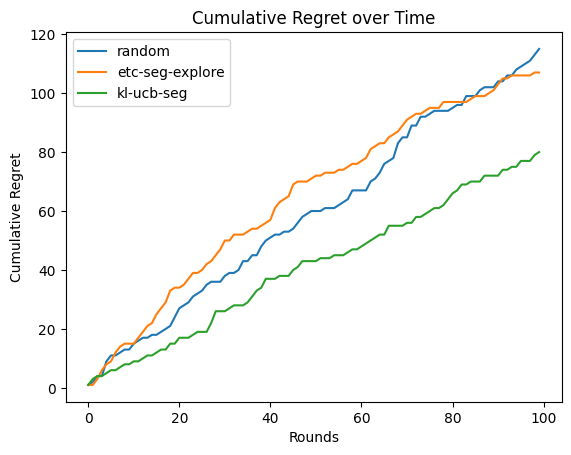

In [ ]:
run_simulation(num=[70000,100], n_rounds=100, n_users_per_round=1000, print_every=10, svd_=[user_features_svd, playlist_svd_cluster])

len policies 3


  1%|          | 1/100 [00:00<00:46,  2.14it/s]

Round: 1/100. Elapsed time: 0.471038 sec.
Cumulative regrets: 
	random : 8.9999994637692
	etc-seg-explore : 15.9999994637692
	kl-ucb-seg : 10.9999994637692 



 10%|█         | 10/100 [00:05<00:46,  1.94it/s]

Round: 10/100. Elapsed time: 5.056609 sec.
Cumulative regrets: 
	random : 119.9999949366902
	etc-seg-explore : 112.9999949366902
	kl-ucb-seg : 107.9999949366902 



 20%|██        | 20/100 [00:10<00:40,  1.95it/s]

Round: 20/100. Elapsed time: 10.227457 sec.
Cumulative regrets: 
	random : 238.99998780319584
	etc-seg-explore : 226.99998780319584
	kl-ucb-seg : 255.99998780319584 



 30%|███       | 30/100 [00:15<00:34,  2.01it/s]

Round: 30/100. Elapsed time: 15.205172 sec.
Cumulative regrets: 
	random : 348.99998289253745
	etc-seg-explore : 288.99998289253745
	kl-ucb-seg : 335.99998289253745 



 40%|████      | 40/100 [00:20<00:32,  1.83it/s]

Round: 40/100. Elapsed time: 20.475106 sec.
Cumulative regrets: 
	random : 434.9999763090709
	etc-seg-explore : 310.9999763090709
	kl-ucb-seg : 408.9999763090709 



 50%|█████     | 50/100 [00:25<00:27,  1.84it/s]

Round: 50/100. Elapsed time: 25.956944 sec.
Cumulative regrets: 
	random : 560.9999691004978
	etc-seg-explore : 324.99996910049776
	kl-ucb-seg : 443.99996910049776 



 60%|██████    | 60/100 [00:30<00:19,  2.10it/s]

Round: 60/100. Elapsed time: 30.746392 sec.
Cumulative regrets: 
	random : 678.9999636592092
	etc-seg-explore : 343.99996365920924
	kl-ucb-seg : 475.99996365920924 



 70%|███████   | 70/100 [00:35<00:14,  2.08it/s]

Round: 70/100. Elapsed time: 35.528020 sec.
Cumulative regrets: 
	random : 789.9999570429336
	etc-seg-explore : 350.9999570429336
	kl-ucb-seg : 501.9999570429336 



 80%|████████  | 80/100 [00:40<00:09,  2.01it/s]

Round: 80/100. Elapsed time: 40.496438 sec.
Cumulative regrets: 
	random : 927.9999510117486
	etc-seg-explore : 353.99995101174864
	kl-ucb-seg : 519.9999510117486 



 90%|█████████ | 90/100 [00:45<00:05,  1.91it/s]

Round: 90/100. Elapsed time: 45.686486 sec.
Cumulative regrets: 
	random : 1042.99994451953
	etc-seg-explore : 361.9999445195299
	kl-ucb-seg : 531.9999445195299 



100%|██████████| 100/100 [00:50<00:00,  1.97it/s]

Round: 100/100. Elapsed time: 50.782385 sec.
Cumulative regrets: 
	random : 1155.9999386939562
	etc-seg-explore : 368.9999386939562
	kl-ucb-seg : 545.9999386939562 

Saving cumulative regrets in results.json


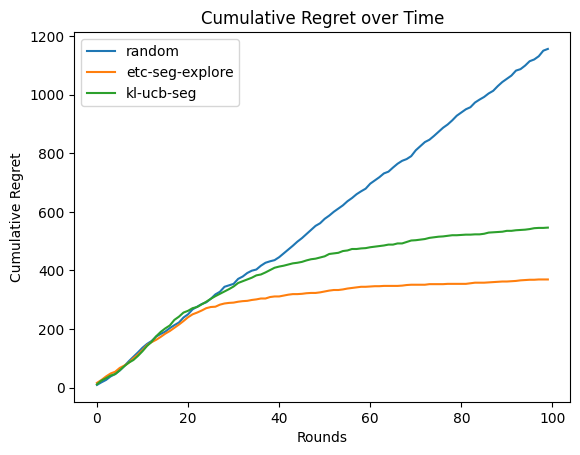

In [ ]:
run_simulation(num=[70000,100], n_rounds=100, n_users_per_round=10000, print_every=10, svd_=[user_features_svd, playlist_svd_cluster])

len policies 3


  1%|          | 1/100 [00:00<01:01,  1.62it/s]

Round: 1/100. Elapsed time: 0.622064 sec.
Cumulative regrets: 
	random : 23.999998649338522
	etc-seg-explore : 18.999998649338522
	kl-ucb-seg : 14.999998649338522 



 10%|█         | 10/100 [00:07<01:06,  1.36it/s]

Round: 10/100. Elapsed time: 7.713197 sec.
Cumulative regrets: 
	random : 172.9999896357167
	etc-seg-explore : 191.9999896357167
	kl-ucb-seg : 154.9999896357167 



 20%|██        | 20/100 [00:14<00:56,  1.42it/s]

Round: 20/100. Elapsed time: 14.949466 sec.
Cumulative regrets: 
	random : 353.99998174975735
	etc-seg-explore : 341.99998174975735
	kl-ucb-seg : 296.99998174975735 



 30%|███       | 30/100 [00:21<00:48,  1.45it/s]

Round: 30/100. Elapsed time: 21.790501 sec.
Cumulative regrets: 
	random : 507.9999720887499
	etc-seg-explore : 414.9999720887499
	kl-ucb-seg : 399.9999720887499 



 40%|████      | 40/100 [00:28<00:41,  1.44it/s]

Round: 40/100. Elapsed time: 28.724698 sec.
Cumulative regrets: 
	random : 671.9999629756512
	etc-seg-explore : 438.9999629756512
	kl-ucb-seg : 509.9999629756512 



 50%|█████     | 50/100 [00:35<00:33,  1.51it/s]

Round: 50/100. Elapsed time: 35.439471 sec.
Cumulative regrets: 
	random : 851.9999539057972
	etc-seg-explore : 463.99995390579716
	kl-ucb-seg : 565.9999539057972 



 60%|██████    | 60/100 [00:42<00:26,  1.49it/s]

Round: 60/100. Elapsed time: 42.183147 sec.
Cumulative regrets: 
	random : 1023.9999427477887
	etc-seg-explore : 487.99994274778874
	kl-ucb-seg : 594.9999427477887 



 70%|███████   | 70/100 [00:48<00:20,  1.49it/s]

Round: 70/100. Elapsed time: 48.868066 sec.
Cumulative regrets: 
	random : 1212.9999331859763
	etc-seg-explore : 504.99993318597626
	kl-ucb-seg : 624.9999331859763 



 80%|████████  | 80/100 [00:55<00:13,  1.51it/s]

Round: 80/100. Elapsed time: 55.479104 sec.
Cumulative regrets: 
	random : 1399.9999210131318
	etc-seg-explore : 520.9999210131318
	kl-ucb-seg : 647.9999210131318 



 90%|█████████ | 90/100 [01:02<00:06,  1.50it/s]

Round: 90/100. Elapsed time: 62.148966 sec.
Cumulative regrets: 
	random : 1567.9999133346973
	etc-seg-explore : 531.9999133346973
	kl-ucb-seg : 672.9999133346973 



100%|██████████| 100/100 [01:08<00:00,  1.46it/s]

Round: 100/100. Elapsed time: 68.727330 sec.
Cumulative regrets: 
	random : 1745.9999036270856
	etc-seg-explore : 548.9999036270856
	kl-ucb-seg : 685.9999036270856 

Saving cumulative regrets in results.json


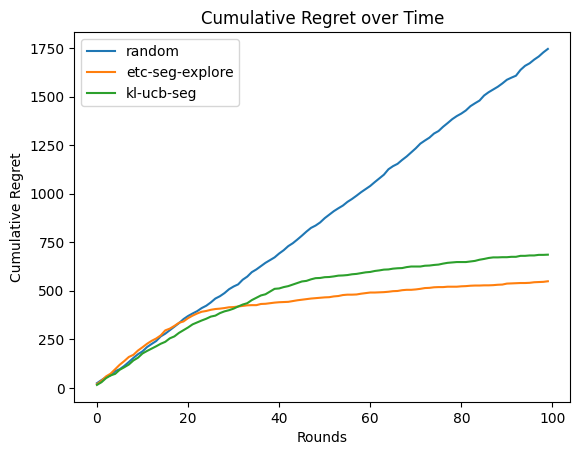

In [ ]:
run_simulation(num=[70000,100], n_rounds=100, n_users_per_round=15000, print_every=10, svd_=[user_features_svd, playlist_svd_cluster])

len policies 10


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
<ipython-input-139-afebf05e8ed5>:47: RuntimeWarning: overflow encountered in exp
  P = (1 + np.exp(1 - X.dot(self.m))) ** (-1)
  1%|          | 1/100 [00:20<33:54, 20.55s/it]

Round: 1/100. Elapsed time: 20.549286 sec.
Cumulative regrets: 
	random : 12.999999485426088
	etc-seg-explore : 16.999999485426088
	kl-ucb-seg : 10.999999485426088
	etc-seg-exploit : 9.999999485426088
	epsilon-greedy-explore : 11.999999485426088
	epsilon-greedy-exploit : 9.999999485426088
	ts-seg-naive : 0.9999994854260876
	ts-seg-pessimistic : 11.999999485426088
	ts-lin-naive : 10.999999485426088
	ts-lin-pessimistic : 18.999999485426088 



<ipython-input-139-afebf05e8ed5>:32: RuntimeWarning: overflow encountered in exp
  return 0.5 * (self.q[:-1] * (w[:-1] - self.m[:-1])).dot(w[:-1] - self.m[:-1]) + np.sum([np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j in range(y.shape[0])])
 10%|█         | 10/100 [02:48<24:42, 16.48s/it]

Round: 10/100. Elapsed time: 168.348338 sec.
Cumulative regrets: 
	random : 107.9999935269152
	etc-seg-explore : 122.9999935269152
	kl-ucb-seg : 107.9999935269152
	etc-seg-exploit : 96.9999935269152
	epsilon-greedy-explore : 82.9999935269152
	epsilon-greedy-exploit : 56.999993526915205
	ts-seg-naive : 61.999993526915205
	ts-seg-pessimistic : 87.9999935269152
	ts-lin-naive : 10.999993526915205
	ts-lin-pessimistic : 18.999993526915205 



 20%|██        | 20/100 [05:30<21:27, 16.10s/it]

Round: 20/100. Elapsed time: 330.863683 sec.
Cumulative regrets: 
	random : 216.9999869814692
	etc-seg-explore : 251.9999869814692
	kl-ucb-seg : 245.9999869814692
	etc-seg-exploit : 143.9999869814692
	epsilon-greedy-explore : 104.99998698146919
	epsilon-greedy-exploit : 85.99998698146919
	ts-seg-naive : 99.99998698146919
	ts-seg-pessimistic : 160.9999869814692
	ts-lin-naive : 10.999986981469192
	ts-lin-pessimistic : 18.999986981469192 



 30%|███       | 30/100 [08:11<18:34, 15.91s/it]

Round: 30/100. Elapsed time: 491.203456 sec.
Cumulative regrets: 
	random : 339.99998071019945
	etc-seg-explore : 290.99998071019945
	kl-ucb-seg : 321.99998071019945
	etc-seg-exploit : 165.99998071019945
	epsilon-greedy-explore : 126.99998071019945
	epsilon-greedy-exploit : 100.99998071019945
	ts-seg-naive : 123.99998071019945
	ts-seg-pessimistic : 237.99998071019945
	ts-lin-naive : 10.999980710199452
	ts-lin-pessimistic : 18.999980710199452 



 40%|████      | 40/100 [10:49<15:41, 15.69s/it]

Round: 40/100. Elapsed time: 649.467701 sec.
Cumulative regrets: 
	random : 451.9999740492349
	etc-seg-explore : 308.9999740492349
	kl-ucb-seg : 364.9999740492349
	etc-seg-exploit : 177.99997404923488
	epsilon-greedy-explore : 142.99997404923488
	epsilon-greedy-exploit : 117.99997404923488
	ts-seg-naive : 136.99997404923488
	ts-seg-pessimistic : 300.9999740492349
	ts-lin-naive : 10.99997404923488
	ts-lin-pessimistic : 18.99997404923488 



 50%|█████     | 50/100 [13:28<13:23, 16.08s/it]

Round: 50/100. Elapsed time: 808.759535 sec.
Cumulative regrets: 
	random : 566.999969174567
	etc-seg-explore : 332.999969174567
	kl-ucb-seg : 401.999969174567
	etc-seg-exploit : 194.999969174567
	epsilon-greedy-explore : 172.999969174567
	epsilon-greedy-exploit : 133.999969174567
	ts-seg-naive : 142.999969174567
	ts-seg-pessimistic : 353.999969174567
	ts-lin-naive : 10.999969174567013
	ts-lin-pessimistic : 18.999969174567013 



 60%|██████    | 60/100 [16:08<10:38, 15.97s/it]

Round: 60/100. Elapsed time: 968.730928 sec.
Cumulative regrets: 
	random : 672.9999623950553
	etc-seg-explore : 347.99996239505526
	kl-ucb-seg : 449.99996239505526
	etc-seg-exploit : 219.99996239505526
	epsilon-greedy-explore : 188.99996239505526
	epsilon-greedy-exploit : 146.99996239505526
	ts-seg-naive : 155.99996239505526
	ts-seg-pessimistic : 405.99996239505526
	ts-lin-naive : 10.999962395055263
	ts-lin-pessimistic : 18.999962395055263 



 70%|███████   | 70/100 [18:49<08:04, 16.16s/it]

Round: 70/100. Elapsed time: 1129.996703 sec.
Cumulative regrets: 
	random : 771.9999581360044
	etc-seg-explore : 355.99995813600435
	kl-ucb-seg : 486.99995813600435
	etc-seg-exploit : 229.99995813600435
	epsilon-greedy-explore : 198.99995813600435
	epsilon-greedy-exploit : 165.99995813600435
	ts-seg-naive : 164.99995813600435
	ts-seg-pessimistic : 475.99995813600435
	ts-lin-naive : 10.999958136004352
	ts-lin-pessimistic : 18.999958136004352 



 80%|████████  | 80/100 [21:28<05:16, 15.84s/it]

Round: 80/100. Elapsed time: 1288.870936 sec.
Cumulative regrets: 
	random : 898.9999524446193
	etc-seg-explore : 370.99995244461934
	kl-ucb-seg : 500.99995244461934
	etc-seg-exploit : 243.99995244461934
	epsilon-greedy-explore : 210.99995244461934
	epsilon-greedy-exploit : 185.99995244461934
	ts-seg-naive : 171.99995244461934
	ts-seg-pessimistic : 520.9999524446193
	ts-lin-naive : 10.999952444619339
	ts-lin-pessimistic : 18.99995244461934 



 90%|█████████ | 90/100 [24:07<02:39, 15.98s/it]

Round: 90/100. Elapsed time: 1447.811557 sec.
Cumulative regrets: 
	random : 999.9999462826436
	etc-seg-explore : 380.9999462826436
	kl-ucb-seg : 511.9999462826436
	etc-seg-exploit : 258.9999462826436
	epsilon-greedy-explore : 232.99994628264358
	epsilon-greedy-exploit : 199.99994628264358
	ts-seg-naive : 177.99994628264358
	ts-seg-pessimistic : 565.9999462826436
	ts-lin-naive : 10.999946282643577
	ts-lin-pessimistic : 18.999946282643577 



100%|██████████| 100/100 [26:46<00:00, 16.06s/it]

Round: 100/100. Elapsed time: 1606.343921 sec.
Cumulative regrets: 
	random : 1113.999938337589
	etc-seg-explore : 382.9999383375889
	kl-ucb-seg : 521.9999383375889
	etc-seg-exploit : 270.9999383375889
	epsilon-greedy-explore : 246.9999383375889
	epsilon-greedy-exploit : 213.9999383375889
	ts-seg-naive : 184.9999383375889
	ts-seg-pessimistic : 614.9999383375889
	ts-lin-naive : 10.999938337588901
	ts-lin-pessimistic : 18.9999383375889 

Saving cumulative regrets in results.json


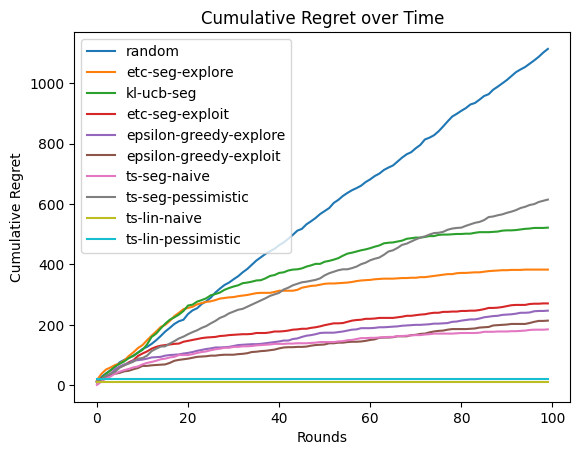

In [ ]:
run_simulation(num=[70000,100], n_rounds=100, n_users_per_round=10000, print_every=10, svd_=[user_features_svd, playlist_svd_cluster])

len policies 11


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
<ipython-input-139-afebf05e8ed5>:32: RuntimeWarning: overflow encountered in exp
  return 0.5 * (self.q[:-1] * (w[:-1] - self.m[:-1])).dot(w[:-1] - self.m[:-1]) + np.sum([np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j in range(y.shape[0])])
  1%|          | 1/100 [00:20<33:59, 20.60s/it]

Round: 1/100. Elapsed time: 20.607880 sec.
Cumulative regrets: 
	random : 17.999998910821887
	etc-seg-explore : 10.999998910821887
	kl-ucb-seg : 6.999998910821887
	etc-seg-exploit : 3.999998910821887
	epsilon-greedy-explore : 5.999998910821887
	epsilon-greedy-exploit : 7.999998910821887
	ts-seg-naive : 6.999998910821887
	ts-seg-pessimistic : 12.999998910821887
	ts-lin-naive : 12.999998910821887
	ts-lin-pessimistic : 7.999998910821887
	most-popular : 16.999998910821887 



 10%|█         | 10/100 [02:53<25:18, 16.87s/it]

Round: 10/100. Elapsed time: 173.176932 sec.
Cumulative regrets: 
	random : 144.99999308341285
	etc-seg-explore : 124.99999308341285
	kl-ucb-seg : 98.99999308341285
	etc-seg-exploit : 94.99999308341285
	epsilon-greedy-explore : 67.99999308341285
	epsilon-greedy-exploit : 49.999993083412846
	ts-seg-naive : 60.999993083412846
	ts-seg-pessimistic : 85.99999308341285
	ts-lin-naive : 12.999993083412846
	ts-lin-pessimistic : 7.999993083412846
	most-popular : 131.99999308341285 



 20%|██        | 20/100 [05:41<22:38, 16.98s/it]

Round: 20/100. Elapsed time: 341.081502 sec.
Cumulative regrets: 
	random : 256.9999869991261
	etc-seg-explore : 228.99998699912612
	kl-ucb-seg : 194.99998699912612
	etc-seg-exploit : 133.99998699912612
	epsilon-greedy-explore : 97.99998699912612
	epsilon-greedy-exploit : 70.99998699912612
	ts-seg-naive : 88.99998699912612
	ts-seg-pessimistic : 182.99998699912612
	ts-lin-naive : 12.999986999126122
	ts-lin-pessimistic : 7.999986999126122
	most-popular : 269.9999869991261 



 30%|███       | 30/100 [08:32<19:53, 17.06s/it]

Round: 30/100. Elapsed time: 512.130857 sec.
Cumulative regrets: 
	random : 360.9999800679507
	etc-seg-explore : 297.9999800679507
	kl-ucb-seg : 278.9999800679507
	etc-seg-exploit : 157.99998006795067
	epsilon-greedy-explore : 124.99998006795067
	epsilon-greedy-exploit : 87.99998006795067
	ts-seg-naive : 100.99998006795067
	ts-seg-pessimistic : 250.99998006795067
	ts-lin-naive : 12.999980067950673
	ts-lin-pessimistic : 7.999980067950673
	most-popular : 407.9999800679507 



 40%|████      | 40/100 [11:23<17:01, 17.02s/it]

Round: 40/100. Elapsed time: 683.639177 sec.
Cumulative regrets: 
	random : 485.99997403148154
	etc-seg-explore : 314.99997403148154
	kl-ucb-seg : 336.99997403148154
	etc-seg-exploit : 172.99997403148154
	epsilon-greedy-explore : 142.99997403148154
	epsilon-greedy-exploit : 100.99997403148154
	ts-seg-naive : 108.99997403148154
	ts-seg-pessimistic : 320.99997403148154
	ts-lin-naive : 12.999974031481543
	ts-lin-pessimistic : 7.999974031481543
	most-popular : 547.9999740314815 



 50%|█████     | 50/100 [14:13<14:05, 16.90s/it]

Round: 50/100. Elapsed time: 853.475603 sec.
Cumulative regrets: 
	random : 589.9999693385107
	etc-seg-explore : 327.9999693385107
	kl-ucb-seg : 389.9999693385107
	etc-seg-exploit : 188.9999693385107
	epsilon-greedy-explore : 164.9999693385107
	epsilon-greedy-exploit : 119.99996933851071
	ts-seg-naive : 114.99996933851071
	ts-seg-pessimistic : 394.9999693385107
	ts-lin-naive : 12.99996933851071
	ts-lin-pessimistic : 7.999969338510709
	most-popular : 706.9999693385107 



 60%|██████    | 60/100 [17:00<11:10, 16.76s/it]

Round: 60/100. Elapsed time: 1020.827222 sec.
Cumulative regrets: 
	random : 701.9999623835356
	etc-seg-explore : 336.9999623835356
	kl-ucb-seg : 430.9999623835356
	etc-seg-exploit : 198.9999623835356
	epsilon-greedy-explore : 185.9999623835356
	epsilon-greedy-exploit : 136.9999623835356
	ts-seg-naive : 124.9999623835356
	ts-seg-pessimistic : 459.9999623835356
	ts-lin-naive : 12.999962383535603
	ts-lin-pessimistic : 7.999962383535603
	most-popular : 840.9999623835356 



 70%|███████   | 70/100 [19:47<08:19, 16.64s/it]

Round: 70/100. Elapsed time: 1187.779509 sec.
Cumulative regrets: 
	random : 816.9999573975292
	etc-seg-explore : 343.9999573975292
	kl-ucb-seg : 463.9999573975292
	etc-seg-exploit : 206.99995739752922
	epsilon-greedy-explore : 205.99995739752922
	epsilon-greedy-exploit : 148.99995739752922
	ts-seg-naive : 131.99995739752922
	ts-seg-pessimistic : 529.9999573975292
	ts-lin-naive : 12.999957397529215
	ts-lin-pessimistic : 7.999957397529215
	most-popular : 985.9999573975292 



 80%|████████  | 80/100 [22:33<05:32, 16.62s/it]

Round: 80/100. Elapsed time: 1353.675138 sec.
Cumulative regrets: 
	random : 949.9999517509896
	etc-seg-explore : 354.99995175098957
	kl-ucb-seg : 483.99995175098957
	etc-seg-exploit : 219.99995175098957
	epsilon-greedy-explore : 222.99995175098957
	epsilon-greedy-exploit : 162.99995175098957
	ts-seg-naive : 139.99995175098957
	ts-seg-pessimistic : 588.9999517509896
	ts-lin-naive : 12.999951750989567
	ts-lin-pessimistic : 7.999951750989567
	most-popular : 1136.9999517509896 



 90%|█████████ | 90/100 [25:19<02:45, 16.51s/it]

Round: 90/100. Elapsed time: 1519.388039 sec.
Cumulative regrets: 
	random : 1084.9999461346615
	etc-seg-explore : 364.9999461346615
	kl-ucb-seg : 489.9999461346615
	etc-seg-exploit : 229.9999461346615
	epsilon-greedy-explore : 240.9999461346615
	epsilon-greedy-exploit : 173.9999461346615
	ts-seg-naive : 152.9999461346615
	ts-seg-pessimistic : 650.9999461346615
	ts-lin-naive : 12.999946134661513
	ts-lin-pessimistic : 7.9999461346615135
	most-popular : 1297.9999461346615 



100%|██████████| 100/100 [28:03<00:00, 16.84s/it]

Round: 100/100. Elapsed time: 1683.743150 sec.
Cumulative regrets: 
	random : 1189.9999399658354
	etc-seg-explore : 370.99993996583544
	kl-ucb-seg : 497.99993996583544
	etc-seg-exploit : 241.99993996583544
	epsilon-greedy-explore : 257.99993996583544
	epsilon-greedy-exploit : 188.99993996583544
	ts-seg-naive : 153.99993996583544
	ts-seg-pessimistic : 719.9999399658354
	ts-lin-naive : 12.999939965835438
	ts-lin-pessimistic : 7.999939965835438
	most-popular : 1456.9999399658354 

Saving cumulative regrets in results.json


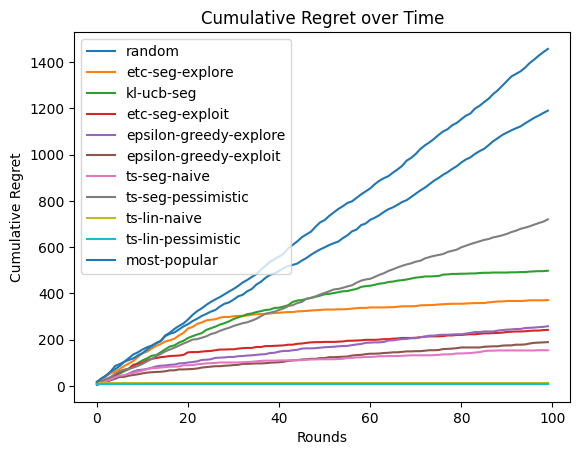

In [ ]:
run_simulation(num=[70000,100], n_rounds=100, n_users_per_round=10000, print_every=10, svd_=[user_features_svd, playlist_svd_cluster])

In [ ]:
def run_simulation_extra_metrics(num, n_rounds, n_users_per_round, print_every, svd_, user_history):
    # Variables de configuración
    output_path = "results.json"
    policies = "random,etc-seg-explore,kl-ucb-seg,etc-seg-exploit,epsilon-greedy-explore,epsilon-greedy-exploit,ts-seg-naive,ts-seg-pessimistic,ts-lin-naive,ts-lin-pessimistic,most-popular"
    n_recos = 12
    l_init = 3
    user_features_svd, playlist_features_svd = svd_
    num_users, num_playlist = num

    # Cargar datos
    user_segment_num = user_embeddings["cluster"][0:num_users].to_numpy()
    len_sample = num_users
    user_features_ = np.concatenate([user_features_svd, np.ones((len_sample, 1))], axis=1)

    # Convert user_features_svd to DataFrame if it's a NumPy array
    if isinstance(user_features_svd, np.ndarray):
        user_features_svd = pd.DataFrame(user_features_svd)

    user_features_svd_num = user_features_svd.head(num_users).to_numpy()
    users_ids = user_features_svd.head(num_users).index.to_list()

    # Convert playlist_features_svd to DataFrame if it's a NumPy array
    if isinstance(playlist_features_svd, np.ndarray):
        playlist_features_svd = pd.DataFrame(playlist_features_svd)

    playlist_features_svd_num = playlist_features_svd.head(num_playlist).to_numpy()
    cont_env = ContextualEnvironment(user_features_svd_num, playlist_features_svd_num, user_segment_num, n_recos)

    # Configuración del entorno y políticas
    n_playlist = num_playlist
    n_users = num_users
    policies_name = policies.split(",")
    policies = set_policies(policies_name, user_segment_num, user_features_svd_num, n_playlist)
    n_policies = len(policies)
    overall_rewards = np.zeros((n_policies, n_rounds))
    overall_optimal_reward = np.zeros(n_rounds)

    # guardar las recomendaciones
    all_recomendations = dict()
    recomendations_per_round = dict()
    for policy in policies_name:
        for user in users_ids:
            all_recomendations[(policy, user)] = set()
            recomendations_per_round[(policy, user)] = []

    # Almacenar métricas adicionales
    diversity_metrics = {policy: [] for policy in policies_name}
    novelty_metrics = {policy: [] for policy in policies_name}
    mrr_metrics = {policy: [] for policy in policies_name}
    ndcg_metrics = {policy: [] for policy in policies_name}

    mean_diversity = {policy: [] for policy in policies_name}
    mean_novelty = {policy: [] for policy in policies_name}
    mean_mrr = {policy: [] for policy in policies_name}
    mean_ndcg = {policy: [] for policy in policies_name}

    # Simulaciones
    start_time = time.time()
    mem_info_before = psutil.virtual_memory().used
    cpu_usage_before = psutil.cpu_percent(interval=None)
    for i in tqdm(range(n_rounds)):
        user_ids = np.random.choice(range(n_users), n_users_per_round, replace=False)
        overall_optimal_reward[i] = np.take(cont_env.th_rewards, user_ids).sum()
        for j in range(n_policies):
            recos = policies[j].recommend_to_users_batch(user_ids, n_recos, l_init)
            rewards = cont_env.simulate_batch_users_reward(batch_user_ids=user_ids, batch_recos=recos)
            for u, user_id in enumerate(user_ids):
                user_policy_key = (policies_name[j], user_id)
                recomendations_per_round[user_policy_key].append(recos[u])
            policies[j].update_policy(user_ids, recos, rewards, l_init)
            # Guardar recompensas
            overall_rewards[j, i] = rewards.sum()

            # Calcular métricas adicionales
            if i > 0:
                diversity_round = cont_env.compute_diversity(recos, recomendations_per_round, user_ids, policies_name[j])
                novelty_round = cont_env.compute_novelty(recos, all_recomendations, user_ids, policies_name[j])
                diversity_metrics[policies_name[j]].extend(diversity_round)  # Extend instead of append
                novelty_metrics[policies_name[j]].extend(novelty_round)
            mrr_metrics[policies_name[j]].append(cont_env.compute_mrr(recos, user_ids, user_history))
            ndcg_metrics[policies_name[j]].append(cont_env.compute_ndcg(recos, user_ids, user_history))

            for u, user_id in enumerate(user_ids):
                for rec in recos[u]:
                    user_policy_key = (policies_name[j], user_id)
                    all_recomendations[user_policy_key].add(rec)

        for j in range(n_policies):
            mean_diversity[policies_name[j]].append(np.mean(diversity_metrics[policies_name[j]]))
            mean_novelty[policies_name[j]].append(np.mean(novelty_metrics[policies_name[j]]))
            mean_mrr[policies_name[j]].append(np.mean(mrr_metrics[policies_name[j]]))
            mean_ndcg[policies_name[j]].append(np.mean(ndcg_metrics[policies_name[j]]))

        if i == 0 or (i + 1) % print_every == 0 or i + 1 == n_rounds:
            mem_info_after = psutil.virtual_memory().used
            memory_used = (mem_info_after - mem_info_before) / (1024 ** 2)  # Convertir a MB
            cpu_usage_after = psutil.cpu_percent(interval=None)
            print(
                  f"Round: {i + 1}/{n_rounds}. Elapsed time: {time.time() - start_time:.2f} sec. "
                  f"Memory used: {memory_used} MB. CPU used: {cpu_usage_after - cpu_usage_before}%")
            print("Round: %d/%d. Elapsed time: %f sec." % (i + 1, n_rounds, time.time() - start_time))
            print("Cumulative regrets: \n%s \n" % "\n".join([
                f"{policies_name[j]} : {np.sum(overall_optimal_reward - overall_rewards[j])}" for j in range(n_policies)
            ]))

            # Imprimir métricas adicionales
            for j in range(n_policies):
                print(f"Policy: {policies_name[j]}")
                if len(diversity_metrics[policies_name[j]]) > 0:
                    print(f"  Diversity: {np.mean(diversity_metrics[policies_name[j]])}")
                    print(f"  Novelty: {np.mean(novelty_metrics[policies_name[j]])}")
                    # mean_diversity[policies_name[j]].append(np.mean(diversity_metrics[policies_name[j]]))
                    # mean_novelty[policies_name[j]].append(np.mean(novelty_metrics[policies_name[j]]))
                else:
                    print("   Diversity: nan")
                    print("   Novelty: nan")
                print(f"  MRR: {np.mean(mrr_metrics[policies_name[j]])}")
                print(f"  NDCG: {np.mean(ndcg_metrics[policies_name[j]])}")
                # mean_mrr[policies_name[j]].append(np.mean(mrr_metrics[policies_name[j]]))
                # mean_ndcg[policies_name[j]].append(np.mean(ndcg_metrics[policies_name[j]]))

    # Guardar resultados
    print("Saving cumulative regrets in %s" % output_path)
    cumulative_regrets = {policies_name[j]: list(np.cumsum(overall_optimal_reward - overall_rewards[j])) for j in range(n_policies)}
    diversity_metrics = {policies_name[j]: diversity_metrics[policies_name[j]] for j in range(n_policies)}
    novelty_metrics = {policies_name[j]: novelty_metrics[policies_name[j]] for j in range(n_policies)}
    mrr_metrics = {policies_name[j]: mrr_metrics[policies_name[j]] for j in range(n_policies)}
    ndcg_metrics = {policies_name[j]: ndcg_metrics[policies_name[j]] for j in range(n_policies)}

    # Graficar resultados
    metrics_to_plot = {
        "Cumulative Regret": cumulative_regrets,
        "Diversity": mean_diversity,
        "Novelty": mean_novelty,
        "MRR": mean_mrr,
        "NDCG": mean_ndcg
    }

    for metric_name, metric_data in metrics_to_plot.items():
        plt.figure(figsize=(10, 6), dpi=500)
        for j in range(n_policies):
            policy_name = policies_name[j]
            if metric_name == "Cumulative Regret":
                plt.plot(metric_data[policy_name], label=policy_name, linestyle="--" if policy_name == "random" else "-")
            else:
                plt.plot(range(1, len(metric_data[policy_name]) + 1), metric_data[policy_name], label=policy_name, linestyle="--" if policy_name == "random" else "-")
        plt.title(f'{metric_name} over Time')
        plt.xlabel('Rounds')
        plt.ylabel(metric_name)
        plt.legend()
        plt.grid(True)
        plt.show()

    return cumulative_regrets, mean_diversity, mean_novelty, mean_mrr, mean_ndcg


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-54-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
<ipython-input-54-afebf05e8ed5>:47: RuntimeWarning: overflow encountered in exp
  P = (1 + np.exp(1 - X.dot(self.m))) ** (-1)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  1%|          | 1/100 [00:33<55:36, 33.70s/it]

Round: 1/100. Elapsed time: 33.69 sec. Memory used: 199.04296875 MB. CPU used: 37.6%
Round: 1/100. Elapsed time: 33.687269 sec.
Cumulative regrets: 
random : 12.99999984193164
etc-seg-explore : 12.99999984193164
kl-ucb-seg : 11.99999984193164
etc-seg-exploit : 9.99999984193164
epsilon-greedy-explore : 12.99999984193164
epsilon-greedy-exploit : 9.99999984193164
ts-seg-naive : 11.99999984193164
ts-seg-pessimistic : 15.99999984193164
ts-lin-naive : 10.99999984193164
ts-lin-pessimistic : 11.99999984193164
most-popular : 5.99999984193164 

Policy: random
   Diversity: nan
   Novelty: nan
  MRR: 0.17151479076479076
  NDCG: 0.0968855269202659
Policy: etc-seg-explore
   Diversity: nan
   Novelty: nan
  MRR: 0.17238499999999998
  NDCG: 0.09685904699920399
Policy: kl-ucb-seg
   Diversity: nan
   Novelty: nan
  MRR: 0.1774613383838384
  NDCG: 0.09965379471200313
Policy: etc-seg-exploit
   Diversity: nan
   Novelty: nan
  MRR: 0.1757282215007215
  NDCG: 0.0982020982194676
Policy: epsilon-greedy-ex

<ipython-input-54-afebf05e8ed5>:32: RuntimeWarning: overflow encountered in exp
  return 0.5 * (self.q[:-1] * (w[:-1] - self.m[:-1])).dot(w[:-1] - self.m[:-1]) + np.sum([np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j in range(y.shape[0])])
 10%|█         | 10/100 [05:08<47:01, 31.35s/it]

Round: 10/100. Elapsed time: 308.30 sec. Memory used: 2172.43359375 MB. CPU used: 22.9%
Round: 10/100. Elapsed time: 308.304665 sec.
Cumulative regrets: 
random : 136.99999610752457
etc-seg-explore : 114.99999610752457
kl-ucb-seg : 97.99999610752457
etc-seg-exploit : 105.99999610752457
epsilon-greedy-explore : 60.99999610752457
epsilon-greedy-exploit : 47.99999610752457
ts-seg-naive : 68.99999610752457
ts-seg-pessimistic : 82.99999610752457
ts-lin-naive : 10.999996107524566
ts-lin-pessimistic : 11.999996107524566
most-popular : 79.99999610752457 

Policy: random
  Diversity: 0.8799327736069772
  Novelty: 0.836043119660018
  MRR: 0.17324183116883116
  NDCG: 0.09762584210228484
Policy: etc-seg-explore
  Diversity: 0.9305117498112034
  Novelty: 0.9049631291368664
  MRR: 0.17371749314574314
  NDCG: 0.09823996684030986
Policy: kl-ucb-seg
  Diversity: 0.8846471354745087
  Novelty: 0.8571457657737698
  MRR: 0.17027982864357863
  NDCG: 0.09674112732697909
Policy: etc-seg-exploit
  Diversity: 0

 20%|██        | 20/100 [10:33<43:41, 32.77s/it]

Round: 20/100. Elapsed time: 633.65 sec. Memory used: 3783.171875 MB. CPU used: 21.0%
Round: 20/100. Elapsed time: 633.653543 sec.
Cumulative regrets: 
random : 249.99999339603892
etc-seg-explore : 236.99999339603892
kl-ucb-seg : 214.99999339603892
etc-seg-exploit : 139.99999339603892
epsilon-greedy-explore : 105.99999339603892
epsilon-greedy-exploit : 85.99999339603892
ts-seg-naive : 103.99999339603892
ts-seg-pessimistic : 149.99999339603892
ts-lin-naive : 10.999993396038917
ts-lin-pessimistic : 12.999993396038917
most-popular : 181.99999339603892 

Policy: random
  Diversity: 0.8802473167521253
  Novelty: 0.7792285709280824
  MRR: 0.17283074927849923
  NDCG: 0.0974882585091254
Policy: etc-seg-explore
  Diversity: 0.8753043600119117
  Novelty: 0.7909325115300205
  MRR: 0.171819178030303
  NDCG: 0.09794592681455867
Policy: kl-ucb-seg
  Diversity: 0.8711302798485518
  Novelty: 0.7936288972470589
  MRR: 0.17113751154401155
  NDCG: 0.09671178351206693
Policy: etc-seg-exploit
  Diversity: 

 29%|██▉       | 29/100 [15:30<39:00, 32.96s/it]

Round: 30/100. Elapsed time: 963.60 sec. Memory used: 5007.16015625 MB. CPU used: 19.799999999999997%
Round: 30/100. Elapsed time: 963.602006 sec.
Cumulative regrets: 
random : 384.99999002441655
etc-seg-explore : 276.99999002441655
kl-ucb-seg : 309.99999002441655
etc-seg-exploit : 157.99999002441655
epsilon-greedy-explore : 130.99999002441655
epsilon-greedy-exploit : 105.99999002441655
ts-seg-naive : 117.99999002441655
ts-seg-pessimistic : 215.99999002441655
ts-lin-naive : 10.999990024416547
ts-lin-pessimistic : 12.999990024416547
most-popular : 275.99999002441655 

Policy: random
  Diversity: 0.880262975358524
  Novelty: 0.7229311535771471
  MRR: 0.17351491005291
  NDCG: 0.09782763048815417
Policy: etc-seg-explore
  Diversity: 0.7717589060178844
  Novelty: 0.6589709019023012
  MRR: 0.17311674999999996
  NDCG: 0.09806907399030049
Policy: kl-ucb-seg
  Diversity: 0.8345367223310847
  Novelty: 0.6996975451008952
  MRR: 0.1728469278499278
  NDCG: 0.09733893317753047
Policy: etc-seg-exploi

 30%|███       | 30/100 [16:03<38:36, 33.09s/it]

  Diversity: 0.3537866110600516
  Novelty: 0.25438183883330157
  MRR: 0.16964518013468013
  NDCG: 0.0979411809393857
Policy: ts-lin-pessimistic
  Diversity: 0.3661358893879226
  Novelty: 0.26445548002612695
  MRR: 0.17567824639249643
  NDCG: 0.09935211298976764
Policy: most-popular
  Diversity: 0.0
  Novelty: 0.0
  MRR: 0.1913529363876864
  NDCG: 0.10155756575017494


 39%|███▉      | 39/100 [21:00<33:36, 33.06s/it]

Round: 40/100. Elapsed time: 1293.36 sec. Memory used: 6024.60546875 MB. CPU used: 19.4%
Round: 40/100. Elapsed time: 1293.363991 sec.
Cumulative regrets: 
random : 485.99998750381747
etc-seg-explore : 294.99998750381747
kl-ucb-seg : 384.99998750381747
etc-seg-exploit : 167.99998750381747
epsilon-greedy-explore : 161.99998750381747
epsilon-greedy-exploit : 119.99998750381747
ts-seg-naive : 134.99998750381747
ts-seg-pessimistic : 288.99998750381747
ts-lin-naive : 10.999987503817465
ts-lin-pessimistic : 12.999987503817465
most-popular : 379.99998750381747 

Policy: random
  Diversity: 0.8801704415812038
  Novelty: 0.6705602098363834
  MRR: 0.17306603634559883
  NDCG: 0.09752096818799354
Policy: etc-seg-explore
  Diversity: 0.6300366688676065
  Novelty: 0.5215752670911049
  MRR: 0.17438349684343432
  NDCG: 0.09834297864670963
Policy: kl-ucb-seg
  Diversity: 0.8017917466778933
  Novelty: 0.6211412882160876
  MRR: 0.17336807756132755
  NDCG: 0.09809115178217633
Policy: etc-seg-exploit
  Div

 40%|████      | 40/100 [21:33<33:09, 33.16s/it]

  Novelty: 0.47014571634530916
  MRR: 0.17952168731962476
  NDCG: 0.10027211406200814
Policy: ts-seg-pessimistic
  Diversity: 0.15500219084368683
  Novelty: 0.10606838461119092
  MRR: 0.17313090954184698
  NDCG: 0.09934269879058778
Policy: ts-lin-naive
  Diversity: 0.3302479792748206
  Novelty: 0.2114078341339504
  MRR: 0.16964093614718617
  NDCG: 0.09774330364041584
Policy: ts-lin-pessimistic
  Diversity: 0.34359647688104633
  Novelty: 0.22168107373551965
  MRR: 0.17566784875541133
  NDCG: 0.09927939202953263
Policy: most-popular
  Diversity: 0.0
  Novelty: 0.0
  MRR: 0.19081102849927847
  NDCG: 0.10141404594664627


 49%|████▉     | 49/100 [26:33<28:26, 33.47s/it]

Round: 50/100. Elapsed time: 1626.88 sec. Memory used: 7020.64453125 MB. CPU used: 19.1%
Round: 50/100. Elapsed time: 1626.883791 sec.
Cumulative regrets: 
random : 616.9999838943822
etc-seg-explore : 308.99998389438224
kl-ucb-seg : 437.99998389438224
etc-seg-exploit : 181.99998389438224
epsilon-greedy-explore : 195.99998389438224
epsilon-greedy-exploit : 129.99998389438224
ts-seg-naive : 144.99998389438224
ts-seg-pessimistic : 366.99998389438224
ts-lin-naive : 10.99998389438224
ts-lin-pessimistic : 12.99998389438224
most-popular : 488.99998389438224 

Policy: random
  Diversity: 0.8802855685597859
  Novelty: 0.6224617140004638
  MRR: 0.17336093203463201
  NDCG: 0.09768057583785437
Policy: etc-seg-explore
  Diversity: 0.5226088351769989
  Novelty: 0.4212316476409065
  MRR: 0.17639102943722942
  NDCG: 0.09915245737537907
Policy: kl-ucb-seg
  Diversity: 0.7654942318111949
  Novelty: 0.5514914428649715
  MRR: 0.1747213605339105
  NDCG: 0.09891331849673089
Policy: etc-seg-exploit
  Diversi

 50%|█████     | 50/100 [27:07<28:03, 33.67s/it]

  Novelty: 0.0
  MRR: 0.1911085886002886
  NDCG: 0.10161612012708755


 59%|█████▉    | 59/100 [32:06<22:45, 33.30s/it]

Round: 60/100. Elapsed time: 1959.95 sec. Memory used: 7928.7890625 MB. CPU used: 18.6%
Round: 60/100. Elapsed time: 1959.948509 sec.
Cumulative regrets: 
random : 721.9999811925481
etc-seg-explore : 315.99998119254815
kl-ucb-seg : 471.99998119254815
etc-seg-exploit : 190.99998119254815
epsilon-greedy-explore : 219.99998119254815
epsilon-greedy-exploit : 142.99998119254815
ts-seg-naive : 154.99998119254815
ts-seg-pessimistic : 410.99998119254815
ts-lin-naive : 10.999981192548148
ts-lin-pessimistic : 12.999981192548148
most-popular : 589.9999811925481 

Policy: random
  Diversity: 0.880202545259007
  Novelty: 0.5784953286604216
  MRR: 0.17365041396103897
  NDCG: 0.09783399967487952
Policy: etc-seg-explore
  Diversity: 0.4417761782121553
  Novelty: 0.34873821945075983
  MRR: 0.1777799918229918
  NDCG: 0.09972321245712618
Policy: kl-ucb-seg
  Diversity: 0.7233724210148961
  Novelty: 0.48953862070483595
  MRR: 0.17593411808561804
  NDCG: 0.09937196749791287
Policy: etc-seg-exploit
  Divers

 60%|██████    | 60/100 [32:40<22:23, 33.58s/it]

  Novelty: 0.15742791734669165
  MRR: 0.1696028322510823
  NDCG: 0.09759373614032936
Policy: ts-lin-pessimistic
  Diversity: 0.3130929582425322
  Novelty: 0.16628207909988263
  MRR: 0.17631274831649837
  NDCG: 0.09932458664523304
Policy: most-popular
  Diversity: 0.0
  Novelty: 0.0
  MRR: 0.19142770033670034
  NDCG: 0.10186915444290334


 69%|██████▉   | 69/100 [37:44<17:29, 33.86s/it]

Round: 70/100. Elapsed time: 2298.88 sec. Memory used: 8869.13671875 MB. CPU used: 18.299999999999997%
Round: 70/100. Elapsed time: 2298.878215 sec.
Cumulative regrets: 
random : 809.9999776920904
etc-seg-explore : 322.9999776920904
kl-ucb-seg : 492.9999776920904
etc-seg-exploit : 195.9999776920904
epsilon-greedy-explore : 244.9999776920904
epsilon-greedy-exploit : 150.9999776920904
ts-seg-naive : 161.9999776920904
ts-seg-pessimistic : 459.9999776920904
ts-lin-naive : 10.999977692090397
ts-lin-pessimistic : 12.999977692090397
most-popular : 687.9999776920904 

Policy: random
  Diversity: 0.8802275710673473
  Novelty: 0.5388008643372526
  MRR: 0.17365737992166563
  NDCG: 0.09785886094532248
Policy: etc-seg-explore
  Diversity: 0.38164225136150587
  Novelty: 0.2968958250330819
  MRR: 0.17840338399299116
  NDCG: 0.09993802075561849
Policy: kl-ucb-seg
  Diversity: 0.6732497250004366
  Novelty: 0.43466333122222534
  MRR: 0.17625806725417434
  NDCG: 0.09939116774070013
Policy: etc-seg-exploi

 70%|███████   | 70/100 [38:19<17:02, 34.08s/it]

  Diversity: 0.12332665609525488
  Novelty: 0.06670756607264648
  MRR: 0.17438865538033388
  NDCG: 0.09974114784207598
Policy: ts-lin-naive
  Diversity: 0.2880918707536444
  Novelty: 0.13955877318713253
  MRR: 0.16955393655947232
  NDCG: 0.09746313537652933
Policy: ts-lin-pessimistic
  Diversity: 0.30162042070832684
  Novelty: 0.14740571840362154
  MRR: 0.17625472247990115
  NDCG: 0.09913000739343876
Policy: most-popular
  Diversity: 0.0
  Novelty: 0.0
  MRR: 0.19137590579262012
  NDCG: 0.10184233401568445


 79%|███████▉  | 79/100 [43:24<11:49, 33.76s/it]

Round: 80/100. Elapsed time: 2637.65 sec. Memory used: 9884.1796875 MB. CPU used: 18.0%
Round: 80/100. Elapsed time: 2637.651014 sec.
Cumulative regrets: 
random : 911.9999748002556
etc-seg-explore : 331.9999748002556
kl-ucb-seg : 515.9999748002556
etc-seg-exploit : 205.9999748002556
epsilon-greedy-explore : 263.9999748002556
epsilon-greedy-exploit : 168.9999748002556
ts-seg-naive : 174.9999748002556
ts-seg-pessimistic : 508.9999748002556
ts-lin-naive : 10.999974800255586
ts-lin-pessimistic : 12.999974800255586
most-popular : 791.9999748002556 

Policy: random
  Diversity: 0.8802065567946709
  Novelty: 0.5027993112338204
  MRR: 0.17369705433802307
  NDCG: 0.09792036424503851
Policy: etc-seg-explore
  Diversity: 0.3393745351033766
  Novelty: 0.25887064994888126
  MRR: 0.17934147014790772
  NDCG: 0.10039556079676955
Policy: kl-ucb-seg
  Diversity: 0.6241969759858778
  Novelty: 0.38782229978680366
  MRR: 0.17726255045995665
  NDCG: 0.09977386666888367
Policy: etc-seg-exploit
  Diversity: 

 80%|████████  | 80/100 [43:58<11:18, 33.95s/it]

  Novelty: 0.1325447956007366
  MRR: 0.17619974869228
  NDCG: 0.09902597282629212
Policy: most-popular
  Diversity: 0.0
  Novelty: 0.0
  MRR: 0.19146327822871578
  NDCG: 0.1019136326632317


 89%|████████▉ | 89/100 [49:02<06:12, 33.90s/it]

Round: 90/100. Elapsed time: 2976.27 sec. Memory used: 10823.58984375 MB. CPU used: 18.200000000000003%
Round: 90/100. Elapsed time: 2976.271771 sec.
Cumulative regrets: 
random : 1038.9999716080492
etc-seg-explore : 339.99997160804924
kl-ucb-seg : 537.9999716080492
etc-seg-exploit : 215.99997160804924
epsilon-greedy-explore : 278.99997160804924
epsilon-greedy-exploit : 176.99997160804924
ts-seg-naive : 179.99997160804924
ts-seg-pessimistic : 560.9999716080492
ts-lin-naive : 10.999971608049236
ts-lin-pessimistic : 12.999971608049236
most-popular : 877.9999716080492 

Policy: random
  Diversity: 0.8801707831325298
  Novelty: 0.47013534136546187
  MRR: 0.1736674923039923
  NDCG: 0.09790369274608432
Policy: etc-seg-explore
  Diversity: 0.307577108433735
  Novelty: 0.22985170682730918
  MRR: 0.18008380747955752
  NDCG: 0.10069574827220688
Policy: kl-ucb-seg
  Diversity: 0.5849431726907631
  Novelty: 0.349393473895582
  MRR: 0.1778993924563091
  NDCG: 0.10015587482721706
Policy: etc-seg-exp

 90%|█████████ | 90/100 [49:37<05:40, 34.09s/it]

  Diversity: 0.28404106425702813
  Novelty: 0.12025973895582323
  MRR: 0.17598670189995197
  NDCG: 0.09878798801739781
Policy: most-popular
  Diversity: 0.0
  Novelty: 0.0
  MRR: 0.19149100485008821
  NDCG: 0.10189668202256826


 99%|█████████▉| 99/100 [54:42<00:33, 33.79s/it]

Round: 100/100. Elapsed time: 3315.77 sec. Memory used: 11636.42578125 MB. CPU used: 17.5%
Round: 100/100. Elapsed time: 3315.767549 sec.
Cumulative regrets: 
random : 1155.9999688633852
etc-seg-explore : 344.9999688633852
kl-ucb-seg : 551.9999688633852
etc-seg-exploit : 223.99996886338522
epsilon-greedy-explore : 295.9999688633852
epsilon-greedy-exploit : 181.99996886338522
ts-seg-naive : 188.99996886338522
ts-seg-pessimistic : 600.9999688633852
ts-lin-naive : 10.99996886338522
ts-lin-pessimistic : 12.99996886338522
most-popular : 965.9999688633852 

Policy: random
  Diversity: 0.8801511648745516
  Novelty: 0.4405969534050179
  MRR: 0.17380126522366515
  NDCG: 0.09796890677525785
Policy: etc-seg-explore
  Diversity: 0.28210358422939075
  Novelty: 0.2060652329749104
  MRR: 0.18059147694805197
  NDCG: 0.10098587194826854
Policy: kl-ucb-seg
  Diversity: 0.550793100358423
  Novelty: 0.3174268817204298
  MRR: 0.17842896042568537
  NDCG: 0.10039406422199286
Policy: etc-seg-exploit
  Diversi

100%|██████████| 100/100 [55:16<00:00, 33.17s/it]

  Diversity: 0.2638601254480288
  Novelty: 0.1040313620071685
  MRR: 0.16919146414141417
  NDCG: 0.09714038285121837
Policy: ts-lin-pessimistic
  Diversity: 0.2766268817204301
  Novelty: 0.10996899641577058
  MRR: 0.1760622904761905
  NDCG: 0.09869596089276002
Policy: most-popular
  Diversity: 0.0
  Novelty: 0.0
  MRR: 0.1914928626623377
  NDCG: 0.10188015836787193
Saving cumulative regrets in results.json


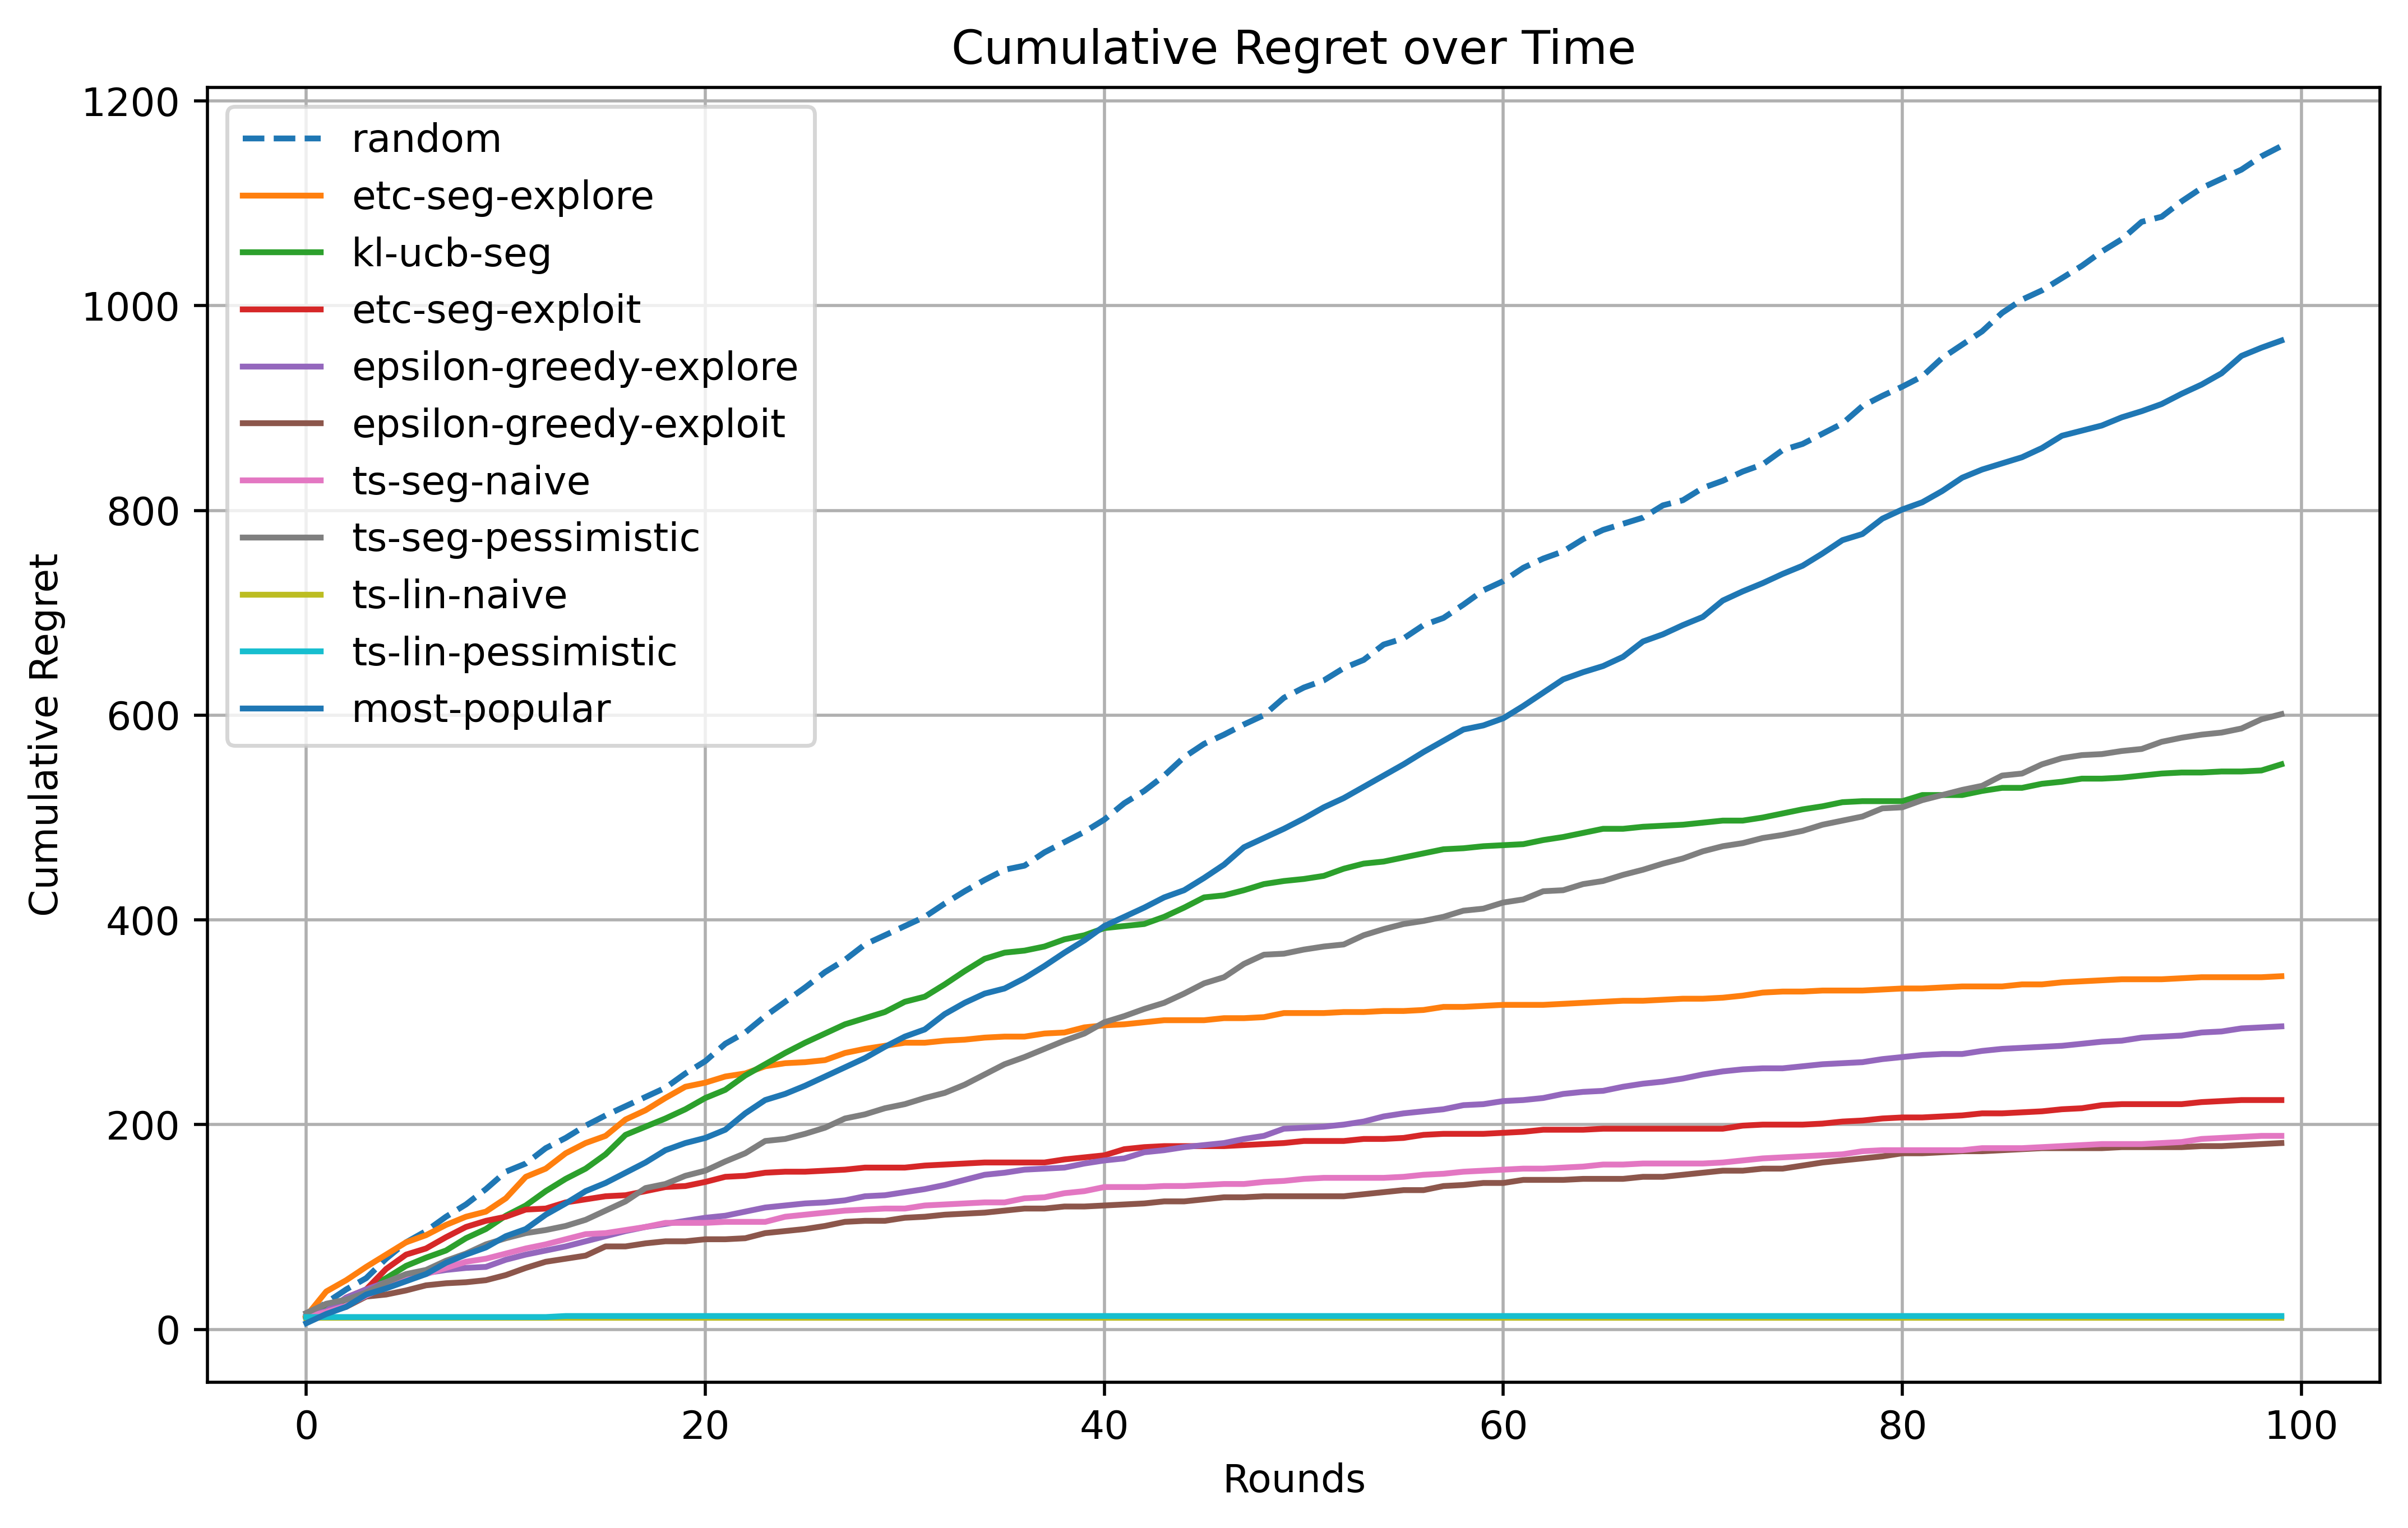

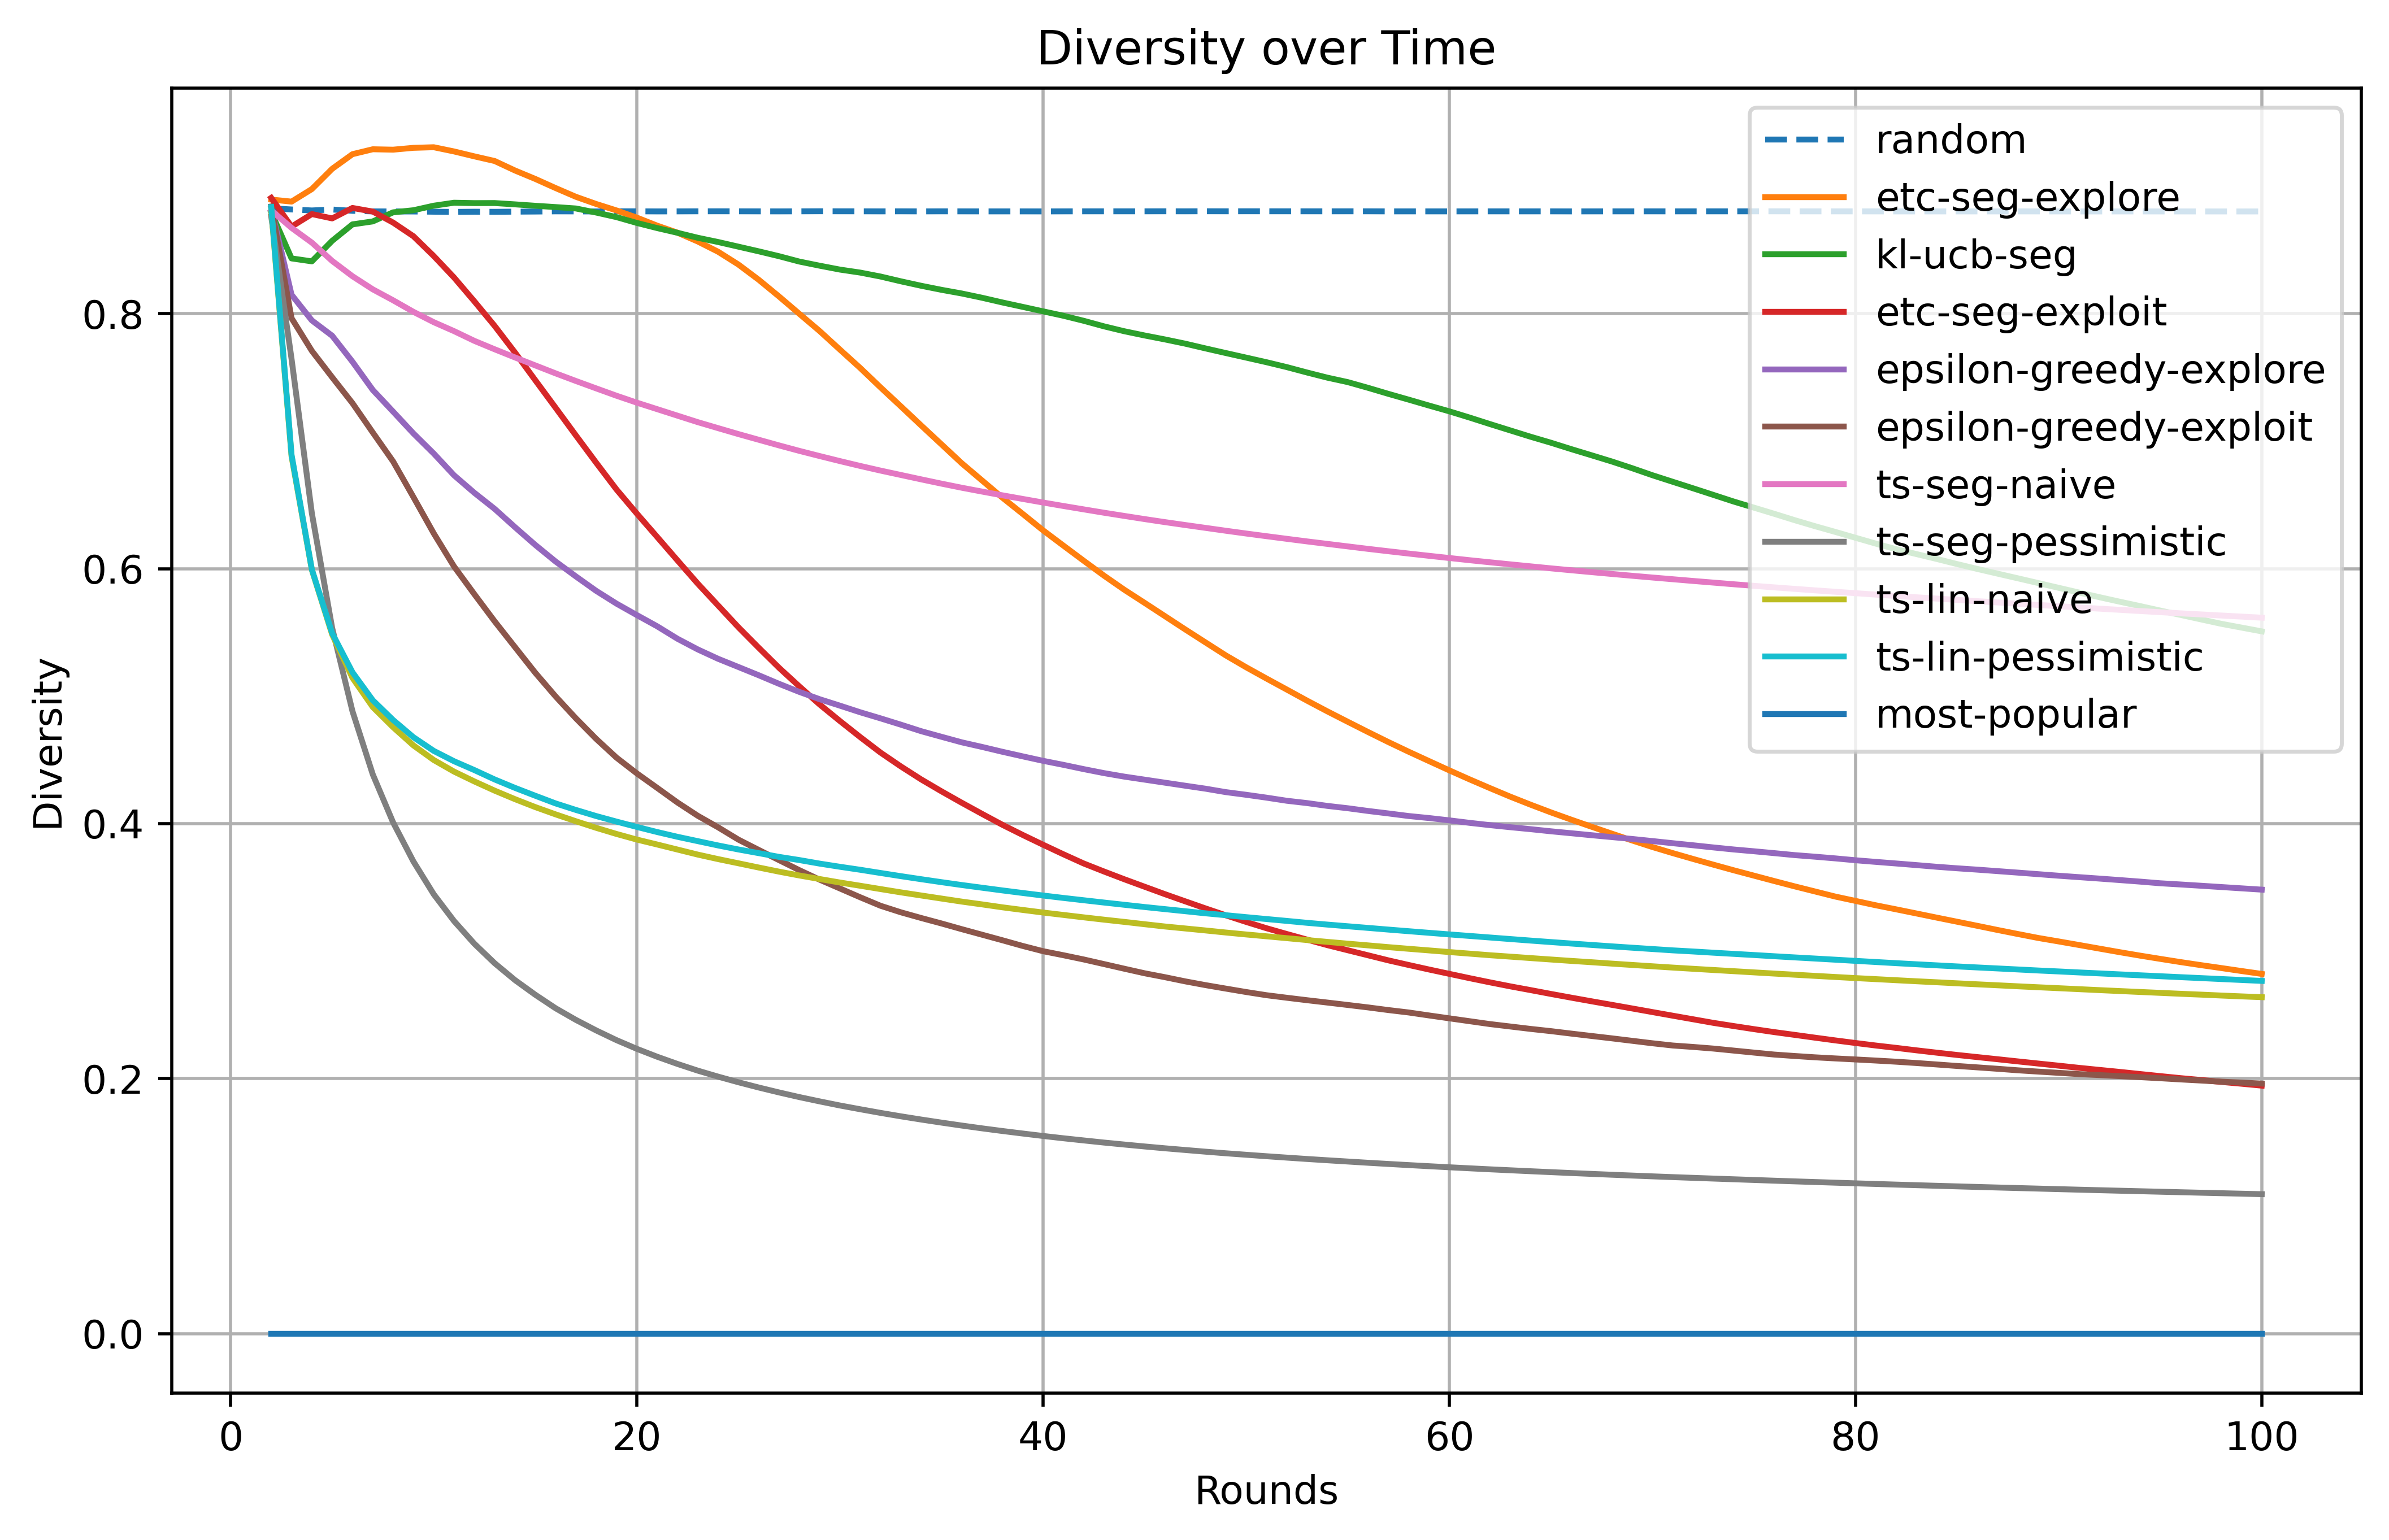

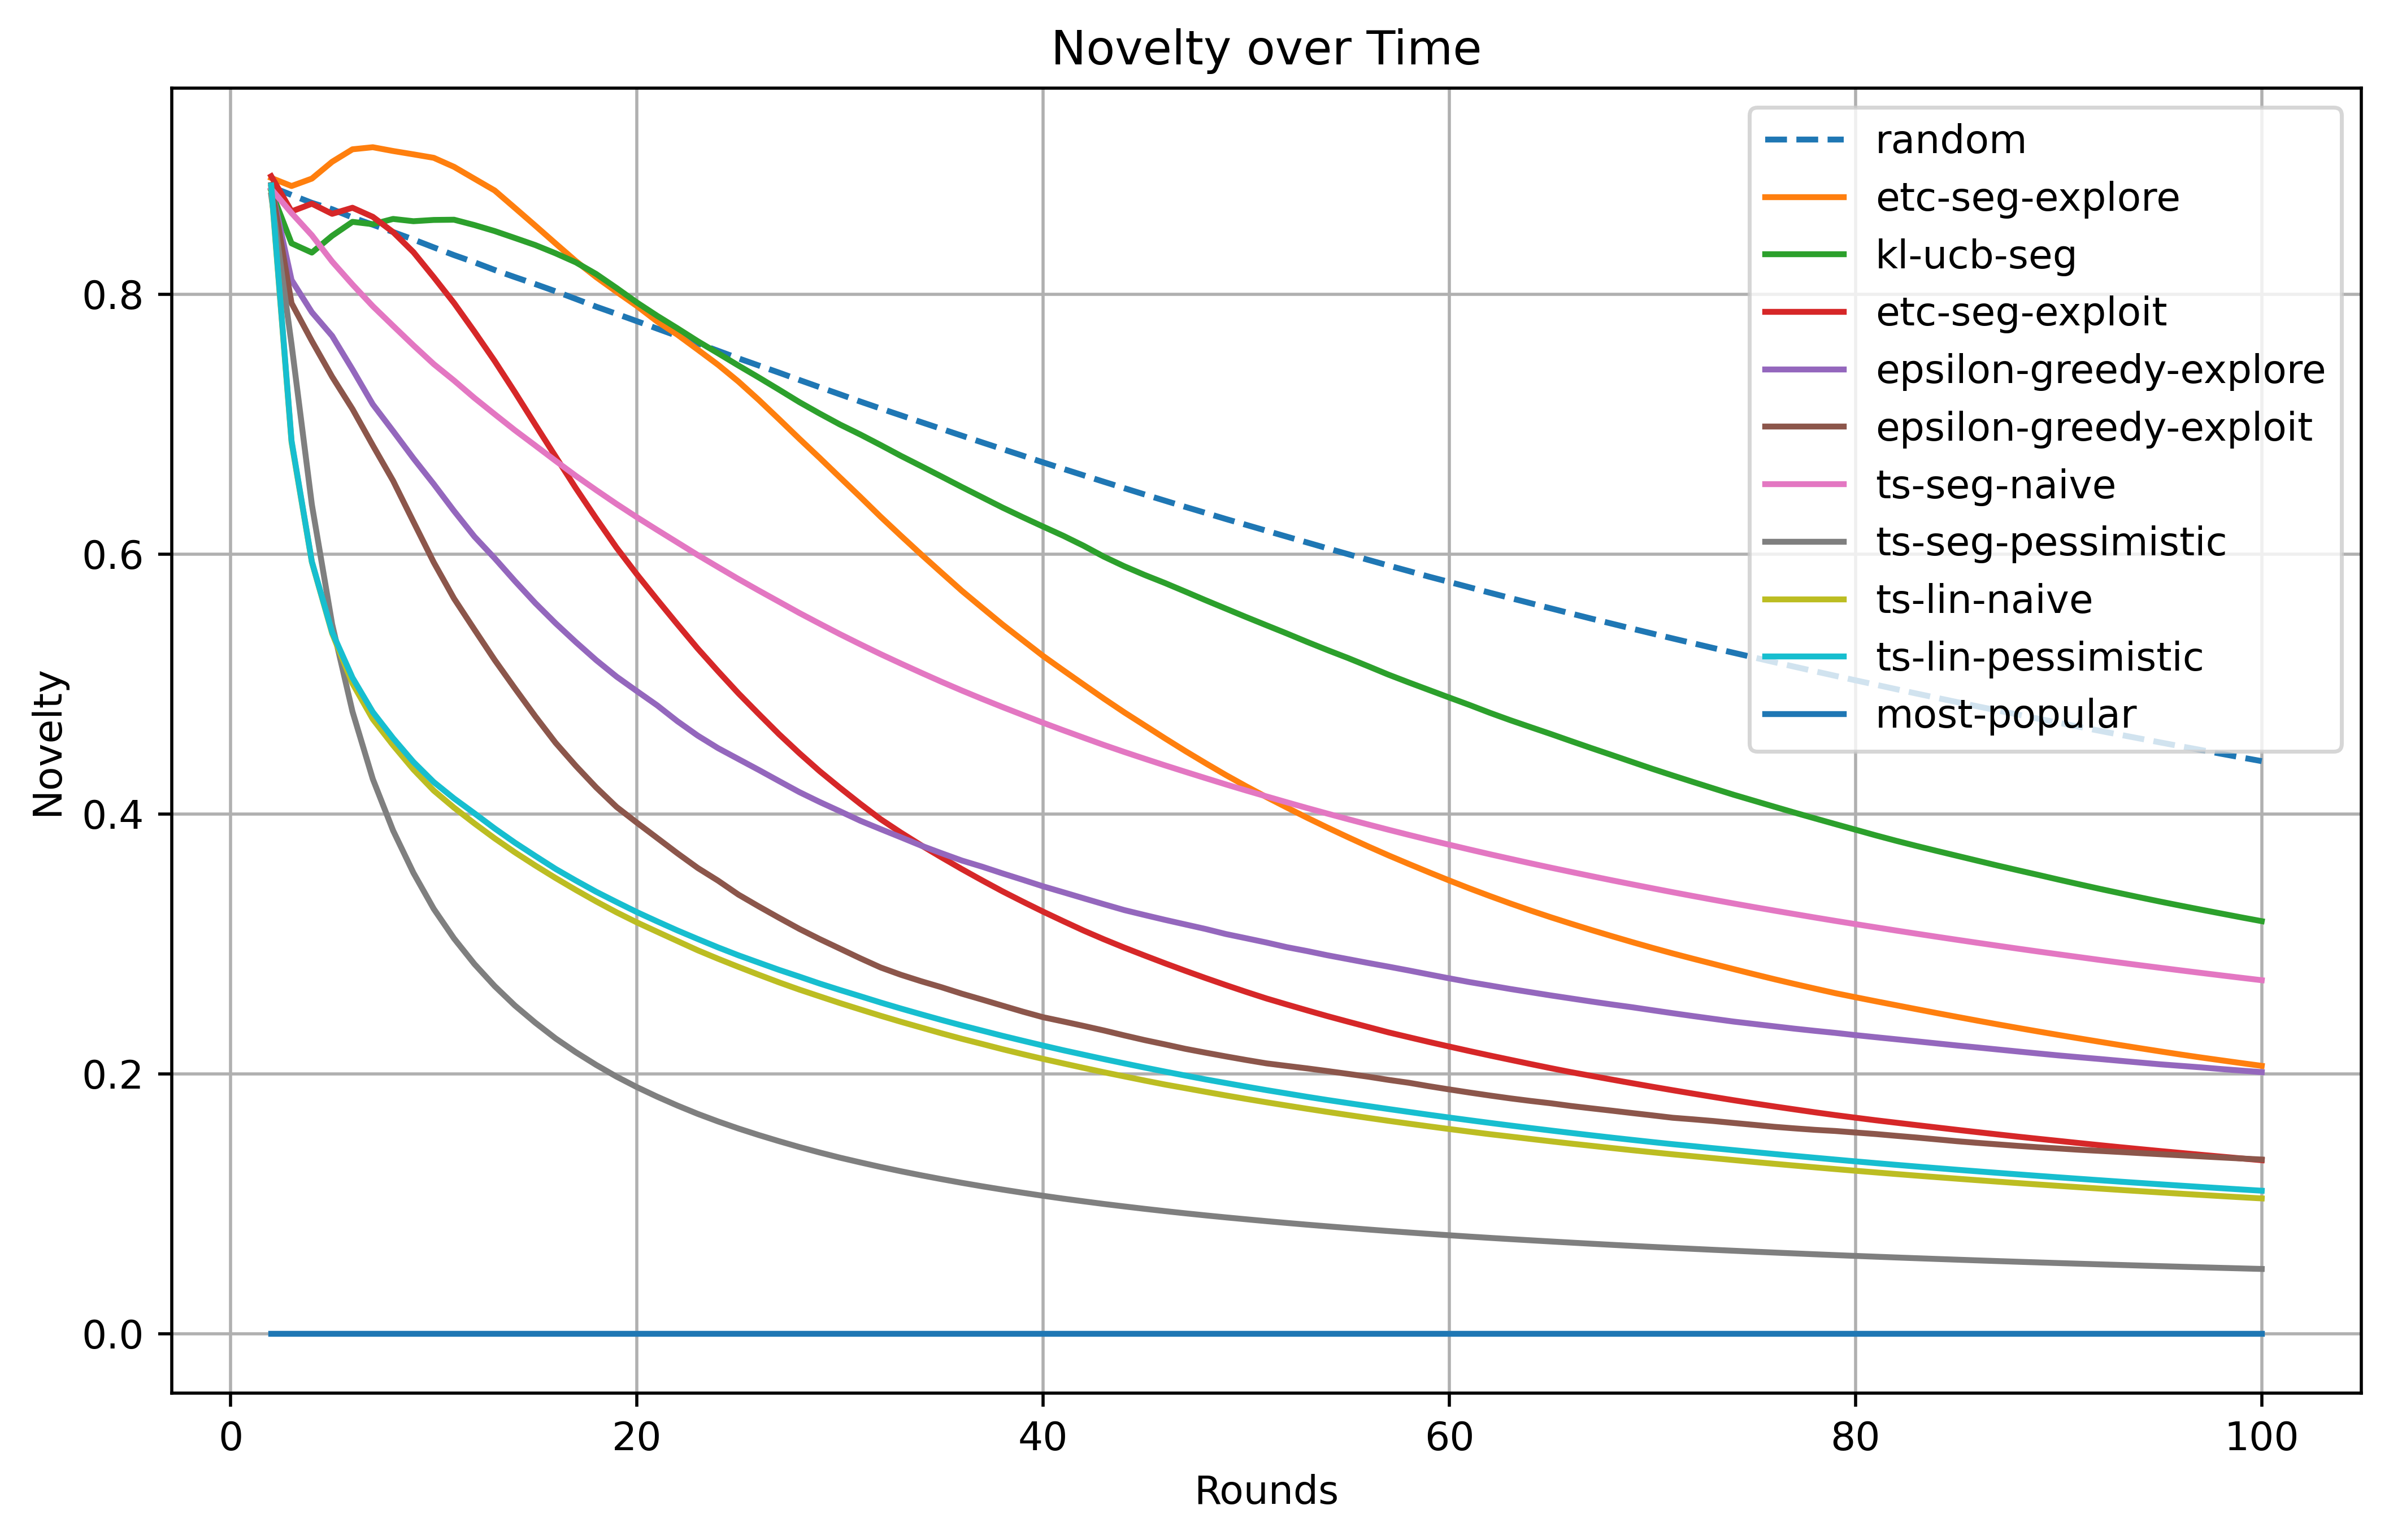

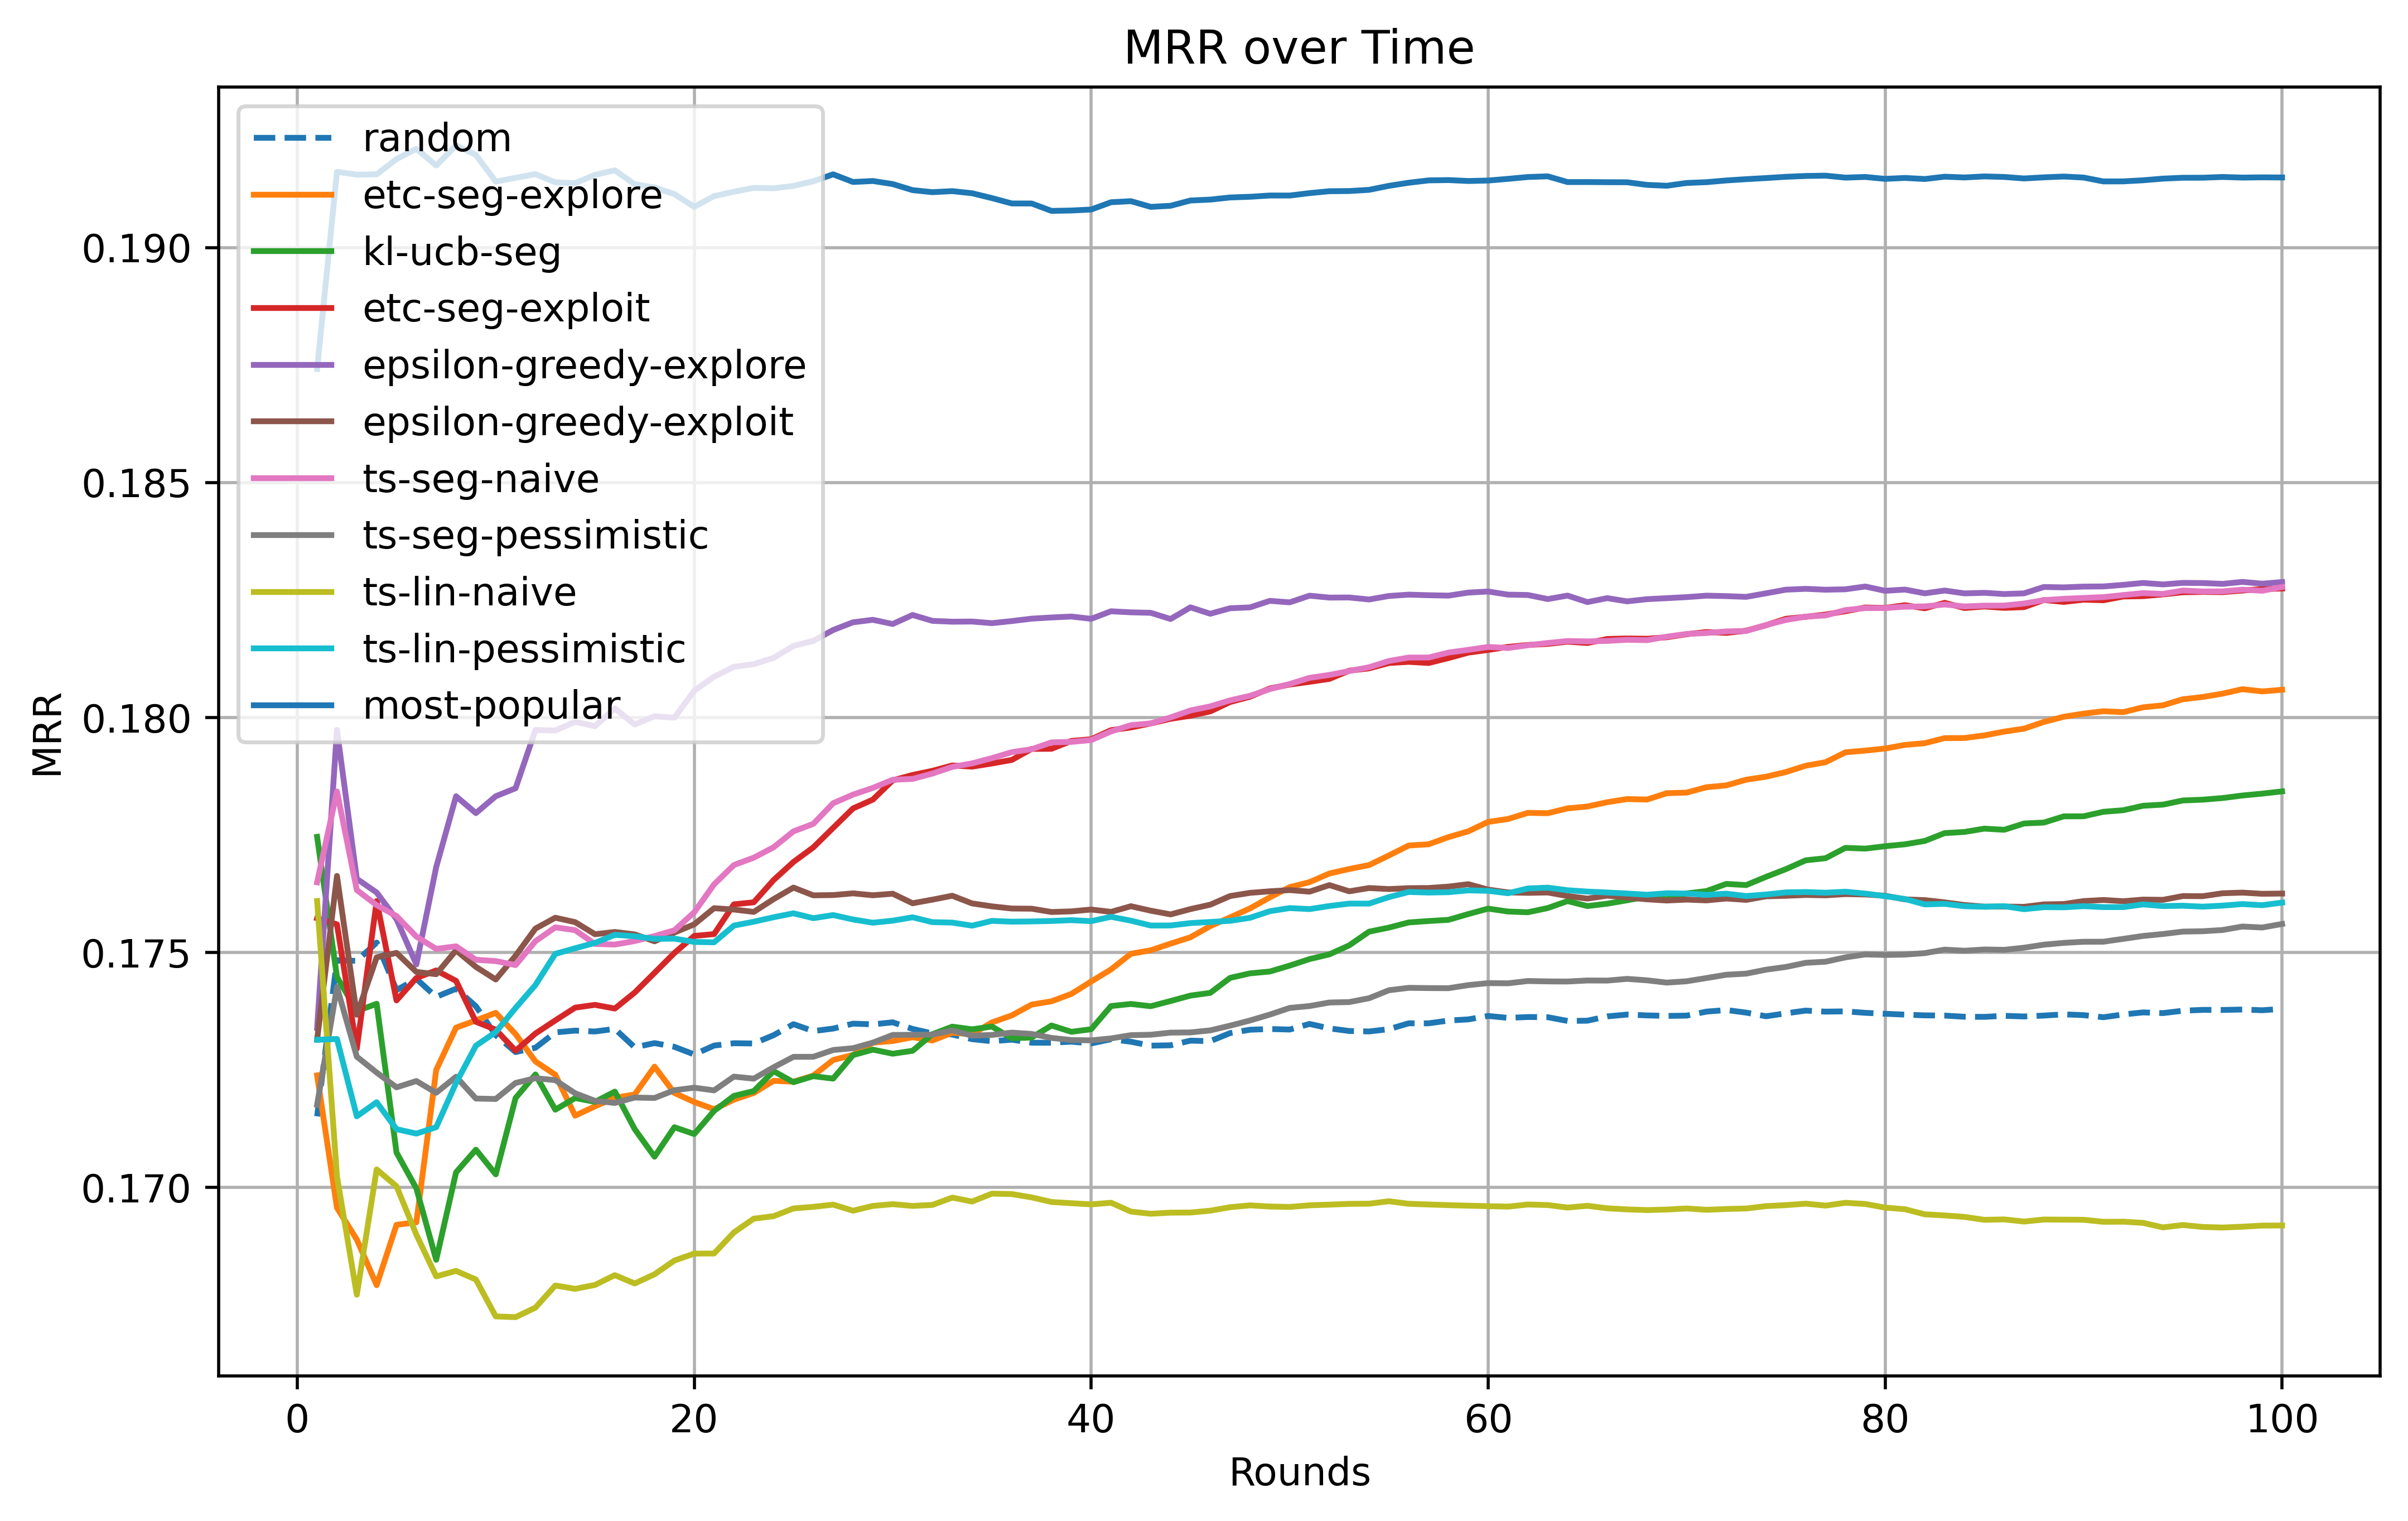

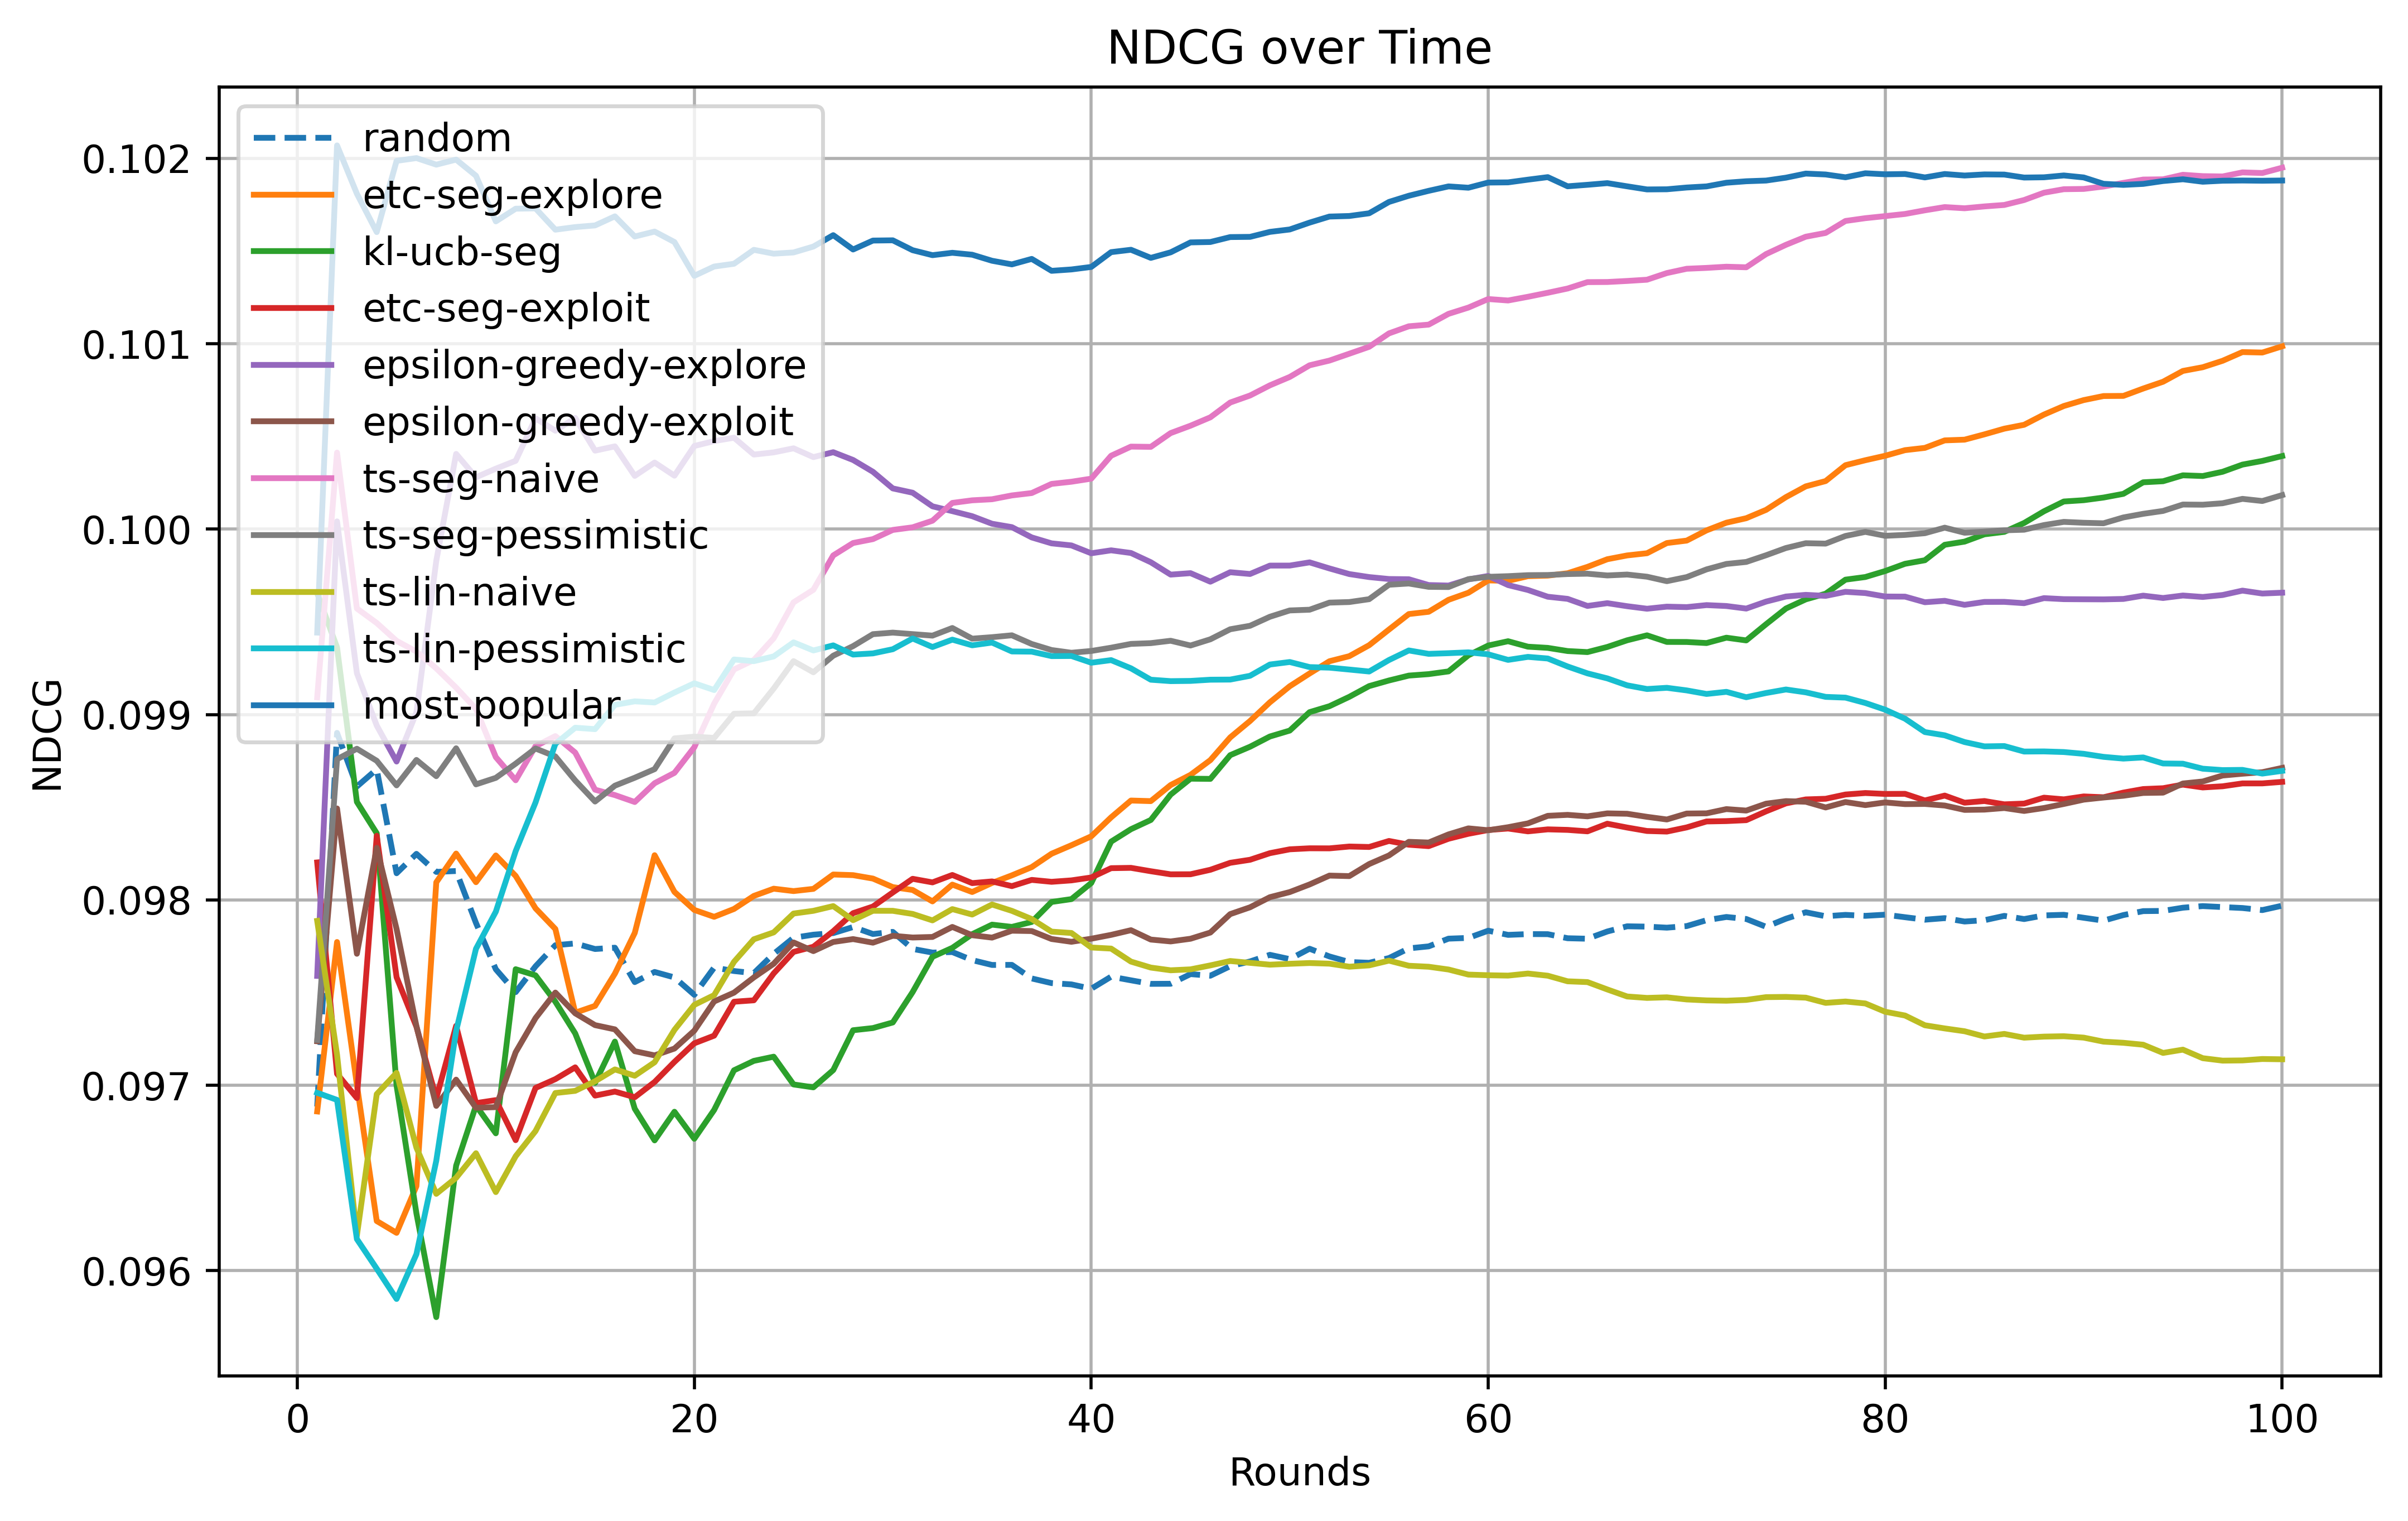

In [ ]:
metrics_run = run_simulation_extra_metrics(num=[70000,100], n_rounds=100, n_users_per_round=10000, print_every=10, svd_=[user_features_svd, playlist_svd_cluster], user_history=user_history_playlists)